# code

## index

In [2]:
import numpy as np
from collections import Counter
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from rtree import index

class IndexCoor(list):
    def __init__(self,ls):
        self.extend(ls)

    def __getitem__(self, item):   # 实现切片
        #cls = type(self)    # 相当于cls=Group()  但软编程可维护性好
        if isinstance(item, slice):
            start = item.start
            stop = item.stop
            L = IndexCoor([])
            for x in range(stop):
                if x>=start:
                    L.append(self[x])
            return L
        if isinstance(item,int):
            return list(self)[item]

    def nodeList(self):
        nodelist = {}
        for i in self:
            if i in nodelist:
                nodelist[i][7] +=1
            else:
                nodelist[i]={5:np.linalg.norm(np.array(i)-
                        np.array(self[0])),7:1}
        return nodelist

    def sideView(self):
        h = []
        nodelist = IndexCoor.nodeList(self)
        for k in nodelist:
            h.append(nodelist[k][7])
        a = Counter(h)
        return a 

    def caculateT(self,deltaR):#按照deltaR计算index积分
        nodelist = IndexCoor.nodeList(self)
        w = []
        delta = deltaR
        #delta = radius/2#qqq
        for key in nodelist:
            w.append([nodelist[key][5],nodelist[key][7]])
        w.sort()
        w = np.array(w)
        R = np.arange(0,np.max(w[:,0]),delta)
        RL = np.zeros((len(R),2)) 
        RL[:,0] = R
        for i in range(len(RL)):
            RL[i,1] = np.sum(w[w[:,0]<RL[i,0],1])
            #RL delta*n 列是sum
        return RL
    
    def landCoor(self):# 根据人口index计算土地index
        nodelist = IndexCoor.nodeList(self)
        land = []
        for key,v in nodelist.items():
            land.append(key)
        landindex = IndexCoor(land)
        return landindex
#    def Rx(self,city):
#        Rrhox = caculate(self,city)
#        return Rrhox

    def spatial_range(self):
        nodelist = IndexCoor.nodeList(self)
        x = []
        y = []
        for k in nodelist.keys():
            x.append(k[0])
            y.append(k[1])
        return max(x),min(x),max(y),min(y)
      
    def paint(self,size = 0.1):
        nodelist = IndexCoor.nodeList(self)
        x = nodelist
        a = []
        c = []
        xmax,xmin,ymax,ymin = IndexCoor.spatial_range(self)
        for k,v in x.items():
            a.append(k)
            c.append(1/(v[7]))
        m = []
        n = []
        for i in a:
            m.append(i[0])
            n.append(i[1])
        plt.figure(figsize=(10,10),dpi=100)
        plt.scatter(m,n,size,c = c)
        plt.xlim((xmin,xmax))
        plt.ylim((ymin,ymax))
        plt.show()
        
    def fun(x, a, n):
        b = 1-x**(-a)
        return 1-np.sign(b)*np.abs(b)**n#numpy 不支持负值的指数
    
    def curveFit(self,deltaR):
        delta = deltaR
        x,y=[],[]
        for a in self.caculate(delta):
            x.append(a[0])
            y.append(a[1])
        popt,pcov = curve_fit(IndexCoor.fun,x,y)
        a = popt[0]
        n = popt[1]
        yvals = IndexCoor.fun(x,a,n)
        plt.plot(x, yvals, 'r',label='polyfit values')
        plt.legend()
        plt.plot(x,y,"b",label = "line")
        return [a,n]
    
    def caculate(self,deltaR):
        #根据nodelist计算s曲线
        nodelist = IndexCoor.nodeList(self)
        w = []
        delta = deltaR
    	#delta = radius/2#qqq
        for key in nodelist:
            w.append([nodelist[key][5],nodelist[key][7]])
        w.sort()
        w = np.array(w)
        R = np.arange(0,np.max(w[:,0]),delta)
        RL = np.zeros((len(R),2)) 
        RL[:,0] = R
        for i in range(len(RL)):
            RL[i,1] = np.sum(w[w[:,0]<RL[i,0],1])
            #RL delta*n 列是sum
        Rrho = np.zeros((len(R),2))
        Rrho[:,0] = R + delta/2
        for i in range(len(Rrho)-1):
            Rrho[i,1] = (RL[i+1,1] - RL[i,1])/(math.pi*(delta**2+2*delta*RL[i,0]))
        a = Rrho
        xx = np.nonzero(a[:,1]==0) 
        if len(xx[0])==0:
            x = 0 
        else:
            x = xx[0][0]
        Rrhox = Rrho[:x,:x]
        return Rrhox
    
    def density(self):
        nodelist = IndexCoor.nodeList(self)
        return len(self)/len(nodelist)
    def curveDensity(self,delta):
        x = []
        y = []
        for a in range(delta,len(self),delta):
            y.append(self[0:a].density())
            x.append(a)
        plt.plot(x,y,"b",label = "line")
        return [x,y]
    
    def createIdx(self):
        idx =index.Index()
        for k,v in enumerate(self):
            i = v[0]
            j = v[1]
            coor = [i,j]
            idx.insert(k,list(np.r_[coor,coor]))
        return idx
    
    def createLimitt(self,rradius):
        L,R,U,D = 0,0,0,0
        for k in self:
            L = min(L,k[0])
            R = max(R,k[0])
            D = min(D,k[1])
            U = max(U,k[1])
        limitt = np.array([L-rradius,D-rradius,R+rradius,U+rradius])
        return limitt

## main

In [1]:
from rtree import index
import numpy as np
import random

def initiate(r0):
    coordinate = np.zeros(2)
    nodelist = {(coordinate[0],coordinate[1]):{5:0.0,7:1}} #5：到心距 7：点数
    index2coor = IndexCoor([(coordinate[0],coordinate[1])])
    #index2coor = [(coordinate[0],coordinate[1])]
    idx = index.Index()
    idx.insert(0,list(np.r_[coordinate,coordinate]))
    limitt = np.r_[coordinate - r0,coordinate + r0] 
    D = 0
    return index2coor,nodelist,idx,limitt,D

def choosenode(index2coor,nodelist,limitt,C,D):#D,城市半径
    white = ( (limitt[2]-limitt[0])*(limitt[3]-limitt[1])-len(nodelist) )*C
    #white = ( (list(limitt)[2]-list(limitt)[0])*(list(limitt)[3]-\
    #list(limitt)[1])-len(nodelist) )*C
    exist = len(index2coor)+len(nodelist)*C
    rnd = random.random()*( exist + white )
    if rnd>exist:
        while 1:
            ii = int( random.random()*(limitt[2]-limitt[0]) + limitt[0] )
            jj = int( random.random()*(limitt[3]-limitt[1]) + limitt[1] )
            d =  int(np.linalg.norm(np.array([ii,jj])))#新生点的距离
            D = max(D,d)
            #if maxR<500:
            if (ii,jj) not in nodelist:
                if D ==d:
                    return (ii,jj),2,D,d#城市增大了
                else:
                    return (ii,jj),0,D,d # 这个结构如果产生不了输出就会死循环，
            #先随机再判断，贝叶斯问题？？
            #用蒙特卡罗验证落到各个空格子概率相等？
    else:
        pos = random.randint(0,len(index2coor)-1)#左闭右闭
        #随机落到落点顺序上  这很重要
        d = nodelist[index2coor[pos]][5]
        return index2coor[pos],1,D,d

def onestep(index2coor,nodelist,idx,limitt,r,C,h,D):
    two,flag,D,d = choosenode(index2coor,nodelist,limitt,C,D)  
    i,j = two[0],two[1]
    if flag == 0:
        #检查新生成的点是否在某点附近
        radius = 10#存活边界
        r = 12#城市边界r,吸引力边界
        intersection = list(idx.intersection([i-radius,j-radius,i+radius,j+radius])) 
        if len(intersection) > 0:
            for key in intersection:
                if np.linalg.norm(np.array(index2coor[key])-np.array((i,j))) <= radius:
                    state = 1
                    break
                else:
                    state = 0
            if state == 1:
                index2coor,nodelist,idx,limitt = \
                insert_newpoint(i,j,nodelist,index2coor,idx,limitt,r)#生成
        return index2coor,nodelist,idx,limitt,D#
    elif flag ==2:
        radius = 10
        r = 12
        intersection = list(idx.intersection([i-radius,j-radius,i+radius,j+radius])) 
        if len(intersection) > 0:
            for key in intersection:
                if np.linalg.norm(np.array(index2coor[key])-np.array((i,j))) <= radius:
                    state = 1
                    break
                else:
                    state = 0
            if state == 1:
                index2coor,nodelist,idx,limitt = \
                insert_newpoint(i,j,nodelist,index2coor,idx,limitt,r)#生成
        return index2coor,nodelist,idx,limitt,D#
    elif flag==1: 
        if getDeltaMax(i,j,nodelist) <= h:
            nodelist[(i,j)][7] += 1
            index2coor.append((i,j))
        else:
            while ((i,j) in nodelist.keys()) and (getDeltaMax(i,j,nodelist) > h ):
            #while getDeltaMax(i,j,nodelist) > h :
                (i,j) = sandpile(i,j,h,nodelist)
            if (i,j) in nodelist.keys():#溢出到有点的格子
                nodelist[(i,j)][7] += 1
                #index2coor[len(index2coor)]=(i,j)
                index2coor.append((i,j))
            else:#溢出到空格子
                index2coor,nodelist,idx,limitt = \
                insert_newpoint(i,j,nodelist,index2coor,idx,limitt,r)
        return index2coor,nodelist,idx,limitt,D#

def insert_newpoint(i,j,nodelist,index2coor,idx,limitt,r):
    #r 是边界的r,用于生成新的limitt
    nodelist[(i,j)] = {5:np.linalg.norm(np.array([i,j])),7:1}
    #index2coor[len(index2coor)+1]=(i,j)
    index2coor.append((i,j))
    newpoint = [i,j]
    #这里前往小心，index2coor已经新增了点，所以要减1
    idx.insert( len(index2coor)-1, np.r_[newpoint, newpoint] )  ###idx
    for x in range(2):
        limitt[x]   = round(min(limitt[x],newpoint[x]-r))
        limitt[x+2] = round(max(limitt[x+2],newpoint[x]+r))
    return index2coor,nodelist,idx,limitt

def sandpile(i,j,h,nodelist):
    r = i
    c = j
    arounddic = {
	1:(r-1,c-1),2:(r -1,c),3:(r -1,c+1),
	4:(r,c-1),5:(r,c),6:(r,c+1),
	7:(r+1,c-1),8:(r+1,c),9:(r+1,c+1)
	}
    pos = 5
    deltas = []
    #邻接阵arov
    arov={}
    fit=[]#满足溢出的位置
    for m in range(1,10):
        if arounddic[m] in nodelist:
            arov[m] = nodelist[arounddic[m]][7]
        else:
            arov[m] = 0
        delta =nodelist[(r,c)][7] - arov[m] 
        if delta == h+1:
            fit.append(m)
    n = int(len(fit))
    if n == 1:
        pos = fit[0]
    else:
        pos = fit[random.randint(0,n-1)]
    return arounddic[pos]   

def getDeltaMax(i,j,nodelist):
    r = i
    c = j
    arounddic = {
	1:(r-1,c-1),2:(r -1,c),3:(r -1,c+1),
	4:(r,c-1),5:(r,c),6:(r,c+1),
	7:(r+1,c-1),8:(r+1,c),9:(r+1,c+1)
	}
    deltas = []
    arov={}
    for m in range(1,10):
        if arounddic[m] in nodelist:
            arov[m] = nodelist[arounddic[m]][7]
        else:
            arov[m] = 0
        delta =nodelist[(r,c)][7] - arov[m] 
        deltas.append(delta)
    return max(deltas)

## radius函数

In [16]:
def rD(D1,D,D0=20,r0=4,maxdelta =10):
    #D1 某一点的距离，D城市半径，D0起点距离，r0
    if D <D0:
        r=r0
    else:
        r = r0
        #吸引边界
    return r

In [ ]:
def fx(r0,maxR):
    if maxR<50:
        radiuss = r0
    else:
        radiuss = r0+10
    return radiuss

In [159]:
rD(20,20)

12

In [115]:
def rD(D1,D,D0=20,r0=10,maxdelta =10):
    #D1 某一点的距离，D城市半径，D0起点距离，r0
    if D <=D0:
        radius=r0
    else:
        k = 4*np.log(3)/(D-D0)
        b = 2*np.log(3)*(D+D0)/(D-D0)
        radius = r0 + int(maxdelta/(1+np.exp(-k*D1+b)))
    return radius

In [77]:
def rD(D1,D,D0 = 20,r0 = 3,maxdelta = 10):
    if D1<=D0:
        radius = r0
    else:
        radius = (3/(D-D0))*(D1-D0)+3
    return radius

In [124]:
def rD(D1,D,D0 = 20,r0 = 3,maxdelta = 10):
    if D1<=D0:
        radius = r0
    elif D1 <=2*D0:
        radius = 0.5*(D1-D0)+3
    else:
        radius = 13
    return radius

In [112]:
rD(30,40)

4.0

## city

In [5]:
class city(object):
    def __init__(self,H,C,maxP,r0=10,gloomyindex=0):
        # H 沙堆阈值 C 引力 maxP 最大人口 radius 引力范围 L 背景范围 
        # deltaP 间隔人口 delta 密度采样间隔
        self.C,self.H,self.maxP = C,H,maxP
        self.r0 = r0
        self.gloomyindex = gloomyindex

    def step(self):
        #index2coor,nodelist,idx,limitt = main.initiate(self.radius,self.C,self.L)#初始化
        index2coor,nodelist,idx,limitt,D = initiate(self.r0)
        i=0
        r = self.r0
        while len(index2coor) < self.maxP:
            k1 = len(index2coor)
            index2coor,nodelist,idx,limitt,D= onestep\
            (index2coor,nodelist,idx,limitt,r,self.C,self.H,D)
            #分次传入函数参数？
            k2 = len(index2coor)
            if k1<k2:
                print(D,r,len(index2coor))
        return index2coor    
    
    def step2(self):
        index2coor = self.gloomyindex
        nodelist = index2coor.nodeList()
        idx = index2coor.createIdx()
        limitt =index2coor.createLimitt(self.r0)
        radiuss = self.r0
        maxR = 0
        while len(index2coor) < self.maxP:
            k1 = len(index2coor)
            index2coor,nodelist,idx,limitt,D = onestep\
            (index2coor,nodelist,idx,limitt,radiuss,self.C,self.H,D)
            radiuss = self.fx(self.r0,maxR)
            k2 = len(index2coor)
            if k1<k2:
                print(D,radiuss,len(index2coor))
        return index2coor    

In [4]:
def fx(r0,maxR):
    radiuss = r0 + int(10/(1+np.exp(-maxR+30)))
    return radiuss
    #radiuss = radius + int(maxR/2)
    #radiuss = radius + int(maxR/10)
    #radiuss = radius + int( np.log10(maxR+1)  )## 改动

# test

In [7]:
demo2 = city(4,0.2,10000,r0 = 12)
popindex2 = demo2.step()

9 12 2
12 12 3
19 12 4
19 12 5
19 12 6
19 12 7
19 12 8
19 12 9
19 12 10
19 12 11
19 12 12
29 12 13
29 12 14
29 12 15
29 12 16
29 12 17
38 12 18
38 12 19
38 12 20
38 12 21
38 12 22
43 12 23
43 12 24
43 12 25
43 12 26
43 12 27
43 12 28
44 12 29
44 12 30
44 12 31
44 12 32
50 12 33
50 12 34
50 12 35
50 12 36
50 12 37
50 12 38
50 12 39
50 12 40
50 12 41
50 12 42
50 12 43
50 12 44
50 12 45
50 12 46
50 12 47
50 12 48
50 12 49
50 12 50
50 12 51
50 12 52
50 12 53
51 12 54
51 12 55
51 12 56
51 12 57
57 12 58
57 12 59
57 12 60
57 12 61
57 12 62
57 12 63
57 12 64
57 12 65
57 12 66
65 12 67
65 12 68
76 12 69
76 12 70
76 12 71
76 12 72
76 12 73
76 12 74
76 12 75
76 12 76
76 12 77
76 12 78
76 12 79
76 12 80
76 12 81
76 12 82
76 12 83
76 12 84
76 12 85
76 12 86
76 12 87
76 12 88
76 12 89
76 12 90
76 12 91
76 12 92
76 12 93
76 12 94
94 12 95
94 12 96
94 12 97
94 12 98
94 12 99
94 12 100
94 12 101
94 12 102
94 12 103
94 12 104
94 12 105
94 12 106
94 12 107
94 12 108
94 12 109
94 12 110
94 12 111
94 12 1

150 12 801
150 12 802
150 12 803
150 12 804
150 12 805
150 12 806
150 12 807
150 12 808
150 12 809
150 12 810
150 12 811
150 12 812
150 12 813
150 12 814
150 12 815
150 12 816
150 12 817
150 12 818
150 12 819
150 12 820
150 12 821
150 12 822
150 12 823
150 12 824
150 12 825
150 12 826
150 12 827
150 12 828
150 12 829
150 12 830
150 12 831
150 12 832
150 12 833
150 12 834
150 12 835
150 12 836
150 12 837
150 12 838
150 12 839
150 12 840
150 12 841
150 12 842
150 12 843
150 12 844
150 12 845
150 12 846
150 12 847
150 12 848
150 12 849
150 12 850
150 12 851
150 12 852
150 12 853
150 12 854
150 12 855
150 12 856
150 12 857
150 12 858
150 12 859
150 12 860
150 12 861
150 12 862
150 12 863
150 12 864
150 12 865
150 12 866
150 12 867
150 12 868
150 12 869
150 12 870
150 12 871
150 12 872
150 12 873
150 12 874
150 12 875
150 12 876
150 12 877
150 12 878
150 12 879
150 12 880
150 12 881
150 12 882
150 12 883
150 12 884
150 12 885
150 12 886
150 12 887
150 12 888
150 12 889
150 12 890
150 12 891

limit_output extension: Maximum message size of 10000 exceeded with 10495 characters

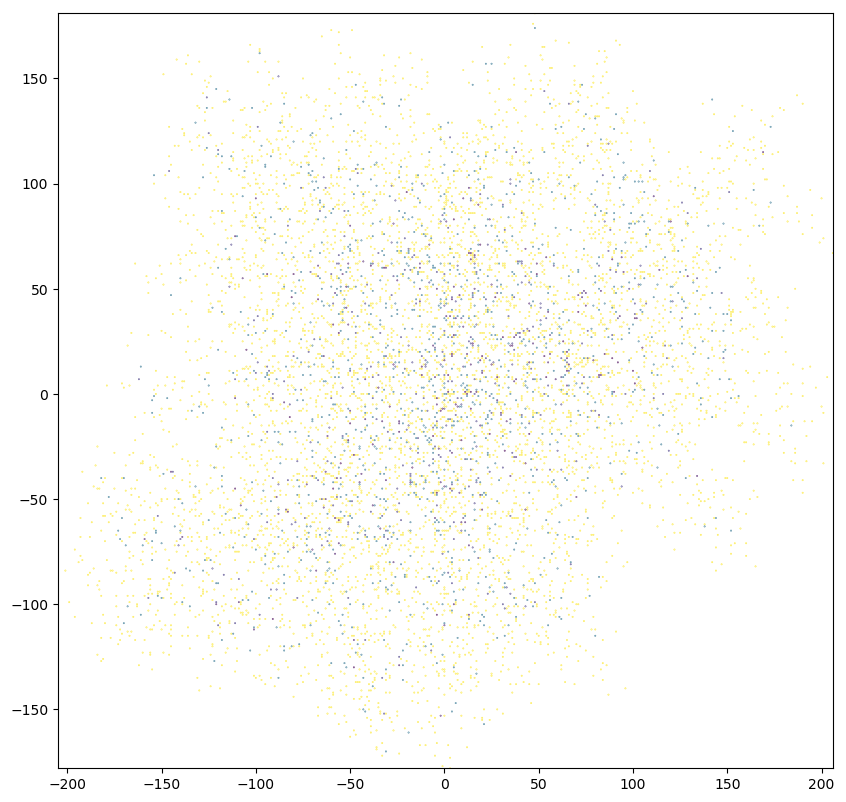

In [8]:
popindex2.paint()

[[500,
  1000,
  1500,
  2000,
  2500,
  3000,
  3500,
  4000,
  4500,
  5000,
  5500,
  6000,
  6500,
  7000,
  7500,
  8000,
  8500,
  9000,
  9500],
 [1.1494252873563218,
  1.1547344110854503,
  1.1727912431587177,
  1.2026458208057726,
  1.2201073694485114,
  1.2381345439537763,
  1.2451085023123443,
  1.2547051442910917,
  1.267248662348634,
  1.2755102040816326,
  1.2892639474917955,
  1.2981393336218088,
  1.3089005235602094,
  1.3162843174125611,
  1.3260254596888261,
  1.3313363288400732,
  1.3385826771653544,
  1.3479107383555489,
  1.354627121060887]]

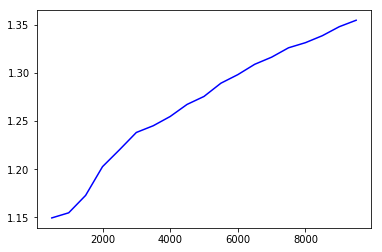

In [9]:
popindex2.curveDensity(500)

In [14]:
demo2 = city(4,0.2,10000,r0 = 12)
popindex2 = demo2.step()

1 12 2
2 12 3
10 12 4
19 12 5
19 12 6
19 12 7
30 12 8
30 12 9
30 12 10
30 12 11
30 12 12
30 12 13
30 12 14
30 12 15
30 12 16
30 12 17
31 12 18
32 12 19
32 12 20
40 12 21
40 12 22
40 12 23
40 12 24
40 12 25
40 12 26
40 12 27
40 12 28
40 12 29
40 12 30
40 12 31
40 12 32
48 12 33
48 12 34
48 12 35
48 12 36
48 12 37
48 12 38
48 12 39
48 12 40
48 12 41
48 12 42
48 12 43
48 12 44
48 12 45
48 12 46
48 12 47
48 12 48
48 12 49
48 12 50
50 12 51
50 12 52
50 12 53
50 12 54
50 12 55
60 12 56
60 12 57
60 12 58
60 12 59
60 12 60
60 12 61
60 12 62
60 12 63
60 12 64
60 12 65
60 12 66
60 12 67
60 12 68
60 12 69
60 12 70
60 12 71
60 12 72
60 12 73
60 12 74
60 12 75
60 12 76
60 12 77
61 12 78
61 12 79
61 12 80
61 12 81
61 12 82
61 12 83
61 12 84
61 12 85
61 12 86
61 12 87
61 12 88
61 12 89
61 12 90
61 12 91
61 12 92
61 12 93
61 12 94
61 12 95
61 12 96
64 12 97
64 12 98
64 12 99
64 12 100
64 12 101
64 12 102
64 12 103
64 12 104
64 12 105
64 12 106
64 12 107
64 12 108
64 12 109
64 12 110
64 12 111
64 12 11

145 12 881
145 12 882
145 12 883
145 12 884
145 12 885
145 12 886
145 12 887
145 12 888
145 12 889
145 12 890
145 12 891
145 12 892
145 12 893
145 12 894
145 12 895
145 12 896
145 12 897
145 12 898
145 12 899
145 12 900
145 12 901
145 12 902
145 12 903
145 12 904
145 12 905
145 12 906
145 12 907
145 12 908
145 12 909
145 12 910
145 12 911
145 12 912
145 12 913
150 12 914
150 12 915
150 12 916
150 12 917
150 12 918
150 12 919
150 12 920
150 12 921
150 12 922
150 12 923
150 12 924
150 12 925
150 12 926
150 12 927
150 12 928
150 12 929
150 12 930
150 12 931
151 12 932
151 12 933
151 12 934
151 12 935
151 12 936
151 12 937
151 12 938
151 12 939
151 12 940
151

limit_output extension: Maximum message size of 10000 exceeded with 10826 characters

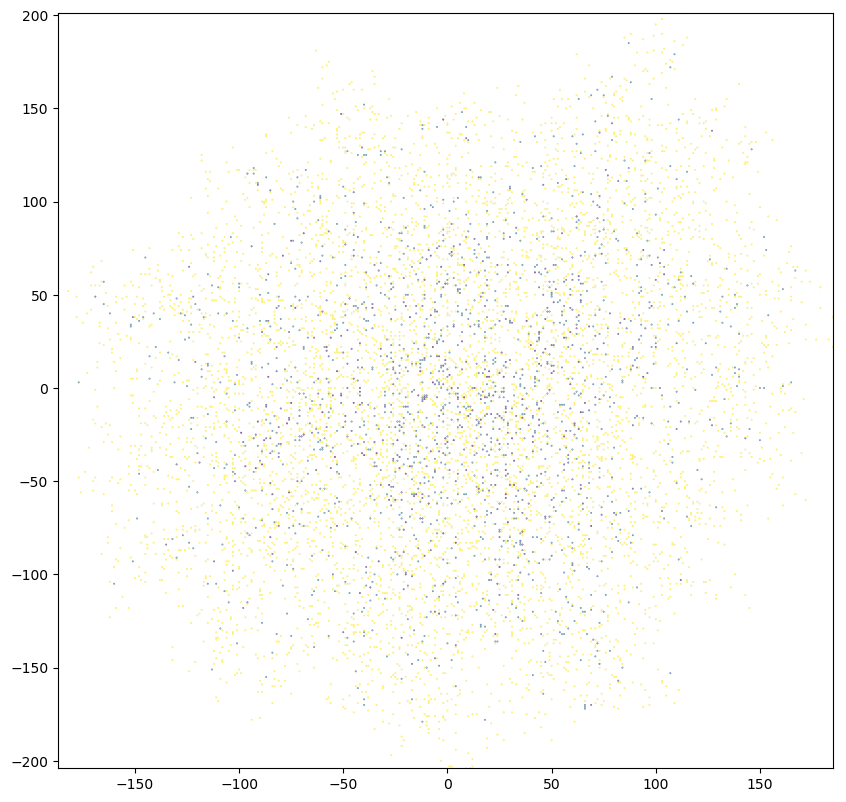

In [15]:
popindex2.paint()

In [18]:
demo2 = city(4,0.2,10000,r0 = 4)
popindex2 = demo2.step()

3 4 2
3 4 3
4 4 4
4 4 5
5 4 6
6 4 7
6 4 8
6 4 9
6 4 10
6 4 11
7 4 12
7 4 13
8 4 14
8 4 15
8 4 16
8 4 17
8 4 18
8 4 19
8 4 20
8 4 21
8 4 22
8 4 23
8 4 24
11 4 25
11 4 26
11 4 27
11 4 28
11 4 29
11 4 30
11 4 31
11 4 32
11 4 33
11 4 34
11 4 35
11 4 36
11 4 37
11 4 38
11 4 39
11 4 40
11 4 41
11 4 42
11 4 43
11 4 44
12 4 45
12 4 46
12 4 47
12 4 48
12 4 49
15 4 50
15 4 51
15 4 52
15 4 53
15 4 54
15 4 55
15 4 56
15 4 57
15 4 58
15 4 59
15 4 60
15 4 61
15 4 62
15 4 63
15 4 64
15 4 65
15 4 66
15 4 67
15 4 68
15 4 69
15 4 70
15 4 71
15 4 72
15 4 73
19 4 74
19 4 75
19 4 76
19 4 77
19 4 78
19 4 79
19 4 80
19 4 81
19 4 82
19 4 83
20 4 84
20 4 85
20 4 86
20 4 87
20 4 88
20 4 89
20 4 90
20 4 91
20 4 92
20 4 93
20 4 94
20 4 95
20 4 96
20 4 97
20 4 98
20 4 99
20 4 100
20 4 101
20 4 102
20 4 103
20 4 104
20 4 105
20 4 106
20 4 107
20 4 108
20 4 109
20 4 110
20 4 111
20 4 112
20 4 113
20 4 114
20 4 115
20 4 116
20 4 117
20 4 118
20 4 119
20 4 120
20 4 121
20 4 122
20 4 123
20 4 124
20 4 125
20 4 126
20 4

31 4 1010
31 4 1011
31 4 1012
31 4 1013
31 4 1014
31 4 1015
31 4 1016
31 4 1017
31 4 1018
31 4 1019
31 4 1020
31 4 1021
31 4 1022
31 4 1023
31 4 1024
31 4 1025
31 4 1026
31 4 1027
31 4 1028
31 4 1029
31 4 1030
31 4 1031
31 4 1032
31 4 1033
31 4 1034
31 4 1035
31 4 1036
31 4 1037
31 4 1038
31 4 1039
31 4 1040
31 4 1041
31 4 1042
31 4 1043
31 4 1044
31 4 1045
31 4 1046
31 4 1047
31 4 1048
31 4 1049
31 4 1050
31 4 1051
31 4 1052
31 4 1053
31 4 1054
31 4 1055
31 4 1056
31 4 1057
31 4 1058
31 4 1059
31 4 1060
31 4 1061
31 4 1062
31 4 1063
31 4 1064
31 4 1065
31 4 1066
31 4 1067
31 4 1068
31 4 1069
31 4 1070
31 4 1071
31 4 1072
31 4 1073
31 4 1074
31 4 1075
31 4 1076
31 4 1077
31 4 1078
31 4 1079
31 4 1080
31 4 1081
31 4 1082
31 4 1083
31 4 1084
31 4 1085
31 4 1086
31 4 1087
31 4 1088
31 4 1089
31 4 1090
31 4 1091
31 4 1092
31 4 1093
31 4 1094
31 4 1095
31 4 1096
31 4 1097
31 4 1098
31 4 1099
31 4 1100
31 4 1101
31 4 1102
31 4 1103
31 4 1104
31 4 1105
31 4 1106
31 4 1107
31 4 1108
31 4 1109


limit_output extension: Maximum message size of 10000 exceeded with 10626 characters

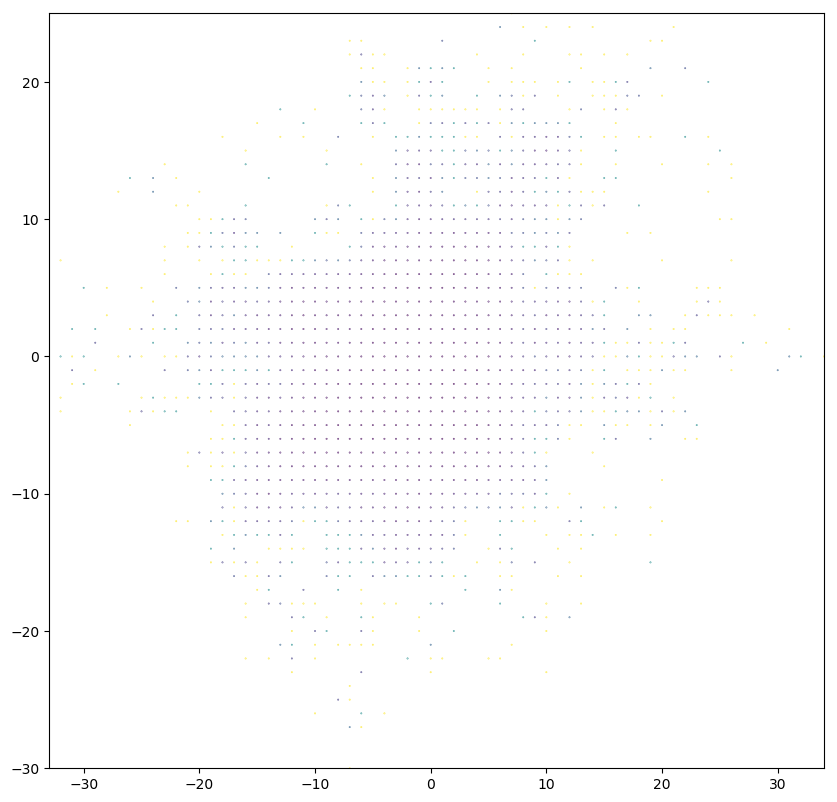

In [20]:
popindex2.paint()

In [14]:
demo2 = city(4,0.2,10000,r0 = 3)
popindex2 = demo2.step()

2 3 2
2 3 3
2 3 4
2 3 5
4 3 6
4 3 7
4 3 8
4 3 9
4 3 10
4 3 11
4 3 12
4 3 13
4 3 14
4 3 15
4 3 16
7 3 17
7 3 18
7 3 19
7 3 20
7 3 21
7 3 22
7 3 23
7 3 24
7 3 25
7 3 26
7 3 27
7 3 28
7 3 29
7 3 30
7 3 31
7 3 32
7 3 33
7 3 34
7 3 35
7 3 36
7 3 37
7 3 38
7 3 39
7 3 40
7 3 41
7 3 42
7 3 43
7 3 44
9 3 45
9 3 46
9 3 47
9 3 48
9 3 49
9 3 50
9 3 51
9 3 52
10 3 53
10 3 54
10 3 55
10 3 56
10 3 57
10 3 58
10 3 59
10 3 60
10 3 61
10 3 62
10 3 63
10 3 64
10 3 65
10 3 66
10 3 67
10 3 68
12 3 69
12 3 70
12 3 71
12 3 72
12 3 73
12 3 74
12 3 75
12 3 76
12 3 77
12 3 78
12 3 79
12 3 80
12 3 81
12 3 82
12 3 83
12 3 84
12 3 85
12 3 86
12 3 87
12 3 88
12 3 89
12 3 90
12 3 91
12 3 92
12 3 93
12 3 94
12 3 95
12 3 96
12 3 97
12 3 98
12 3 99
12 3 100
14 3 101
14 3 102
14 3 103
14 3 104
14 3 105
14 3 106
14 3 107
14 3 108
14 3 109
14 3 110
14 3 111
14 3 112
14 3 113
14 3 114
14 3 115
14 3 116
14 3 117
14 3 118
14 3 119
14 3 120
14 3 121
14 3 122
14 3 123
14 3 124
14 3 125
14 3 126
14 3 127
14 3 128
14 3 129
14 3 

limit_output extension: Maximum message size of 10000 exceeded with 10224 characters

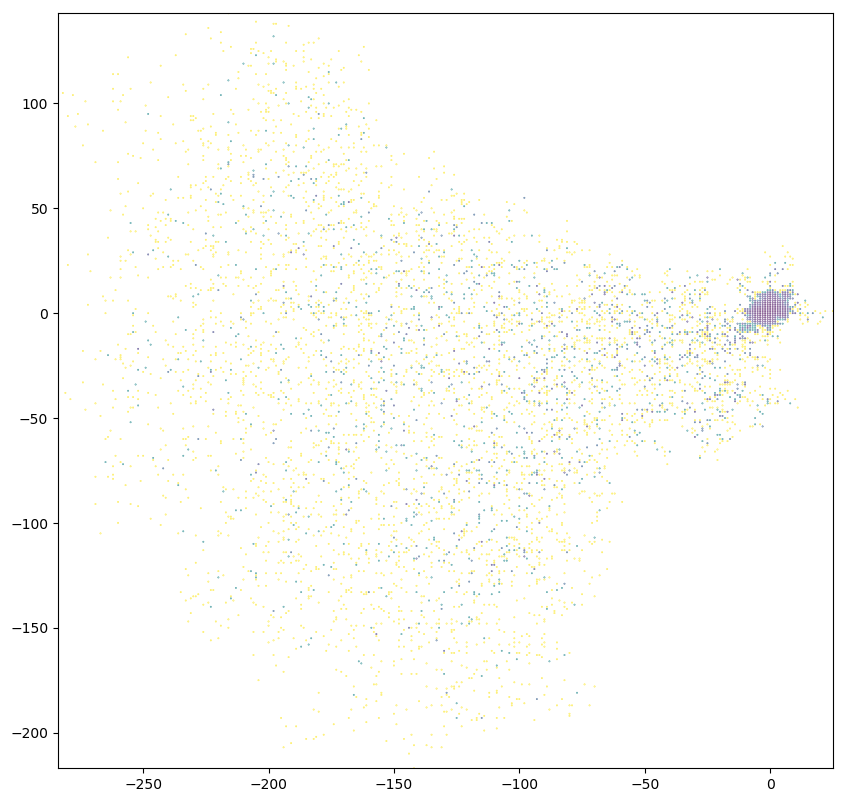

In [23]:
popindex2.paint()

In [22]:
popindex2[500:519]

[(0, 6),
 (-8, -2),
 (0, -2),
 (-12, -12),
 (-6, 5),
 (-1, 2),
 (-11, -8),
 (0, 8),
 (-2, 2),
 (1.0, 0.0),
 (-2, -3),
 (-3, 0),
 (-11, -6),
 (-6, 2),
 (-1, 4),
 (-29, -13),
 (-25, -7),
 (-1.0, -1.0),
 (1, 3)]

### ？？？怎么回事

In [ ]:
#2d0 d0=20

In [22]:
demo2 = city(4,1,10000,r0 = 12)
popindex2 = demo2.step()

9 4 2
16 4 3
16 4 4
27 4 5
27 4 6
27 4 7
27 4 8
27 4 9
27 4 10
27 4 11
27 4 12
27 4 13
27 4 14
27 4 15
27 4 16
27 4 17
27 4 18
27 4 19
27 4 20
36 4 21
36 4 22
36 4 23
36 4 24
36 4 25
36 4 26
36 4 27
46 4 28
46 4 29
46 4 30
46 4 31
46 4 32
46 4 33
46 4 34
46 4 35
46 4 36
46 4 37
46 4 38
53 4 39
53 4 40
53 4 41
53 4 42
53 4 43
53 4 44
53 4 45
53 4 46
53 4 47
53 4 48
53 4 49
53 4 50
53 4 51
53 4 52
53 4 53
53 4 54
53 4 55
53 4 56
53 4 57
53 4 58
53 4 59
53 4 60
53 4 61
61 4 62
61 4 63
61 4 64
61 4 65
61 4 66
61 4 67
61 4 68
61 4 69
61 4 70
61 4 71
61 4 72
61 4 73
61 4 74
61 4 75
61 4 76
61 4 77
61 4 78
61 4 79
61 4 80
61 4 81
61 4 82
61 4 83
61 4 84
61 4 85
61 4 86
61 4 87
61 4 88
61 4 89
61 4 90
61 4 91
61 4 92
61 4 93
61 4 94
61 4 95
61 4 96
61 4 97
61 4 98
61 4 99
61 4 100
61 4 101
61 4 102
61 4 103
61 4 104
61 4 105
61 4 106
61 4 107
68 4 108
68 4 109
68 4 110
68 4 111
68 4 112
68 4 113
68 4 114
68 4 115
68 4 116
68 4 117
68 4 118
68 4 119
68 4 120
68 4 121
68 4 122
68 4 123
68 4 124


156 4 976
156 4 977
156 4 978
156 4 979
156 4 980
156 4 981
156 4 982
156 4 983
156 4 984
156 4 985
156 4 986
161 4 987
161 4 988
161 4 989
161 4 990
161 4 991
161 4 992
161 4 993
161 4 994
161 4 995
161 4 996
161 4 997
161 4 998
161 4 999
161 4 1000
161 4 1001
161 4 1002
161 4 1003
161 4 1004
161 4 1005
161 4 1006
161 4 1007
161 4 1008
161 4 1009
161 4 1010
161 4 1011
161 4 1012
161 4 1013
161 4 1014
161 4 1015
161 4 1016
161 4 1017
161 4 1018
161 4 1019
161 4 1020
161 4 1021
161 4 1022
161 4 1023
161 4 1024
161 4 1025
161 4 1026
161 4 1027
161 4 1028
161 4 1029
161 4 1030
161 4 1031
161 4 1032
161 4 1033
161 4 1034
161 4 1035
161 4 1036
161 4 1037
161 4 1038
161 4 1039
161 4 1040
161 4 1041
161 4 1042
161 4 1043
161 4 1044
161 4 1045
161 4 1046
161 4 1047
161 4 1048
161 4 1049
161 4 105

limit_output extension: Maximum message size of 10000 exceeded with 10646 characters

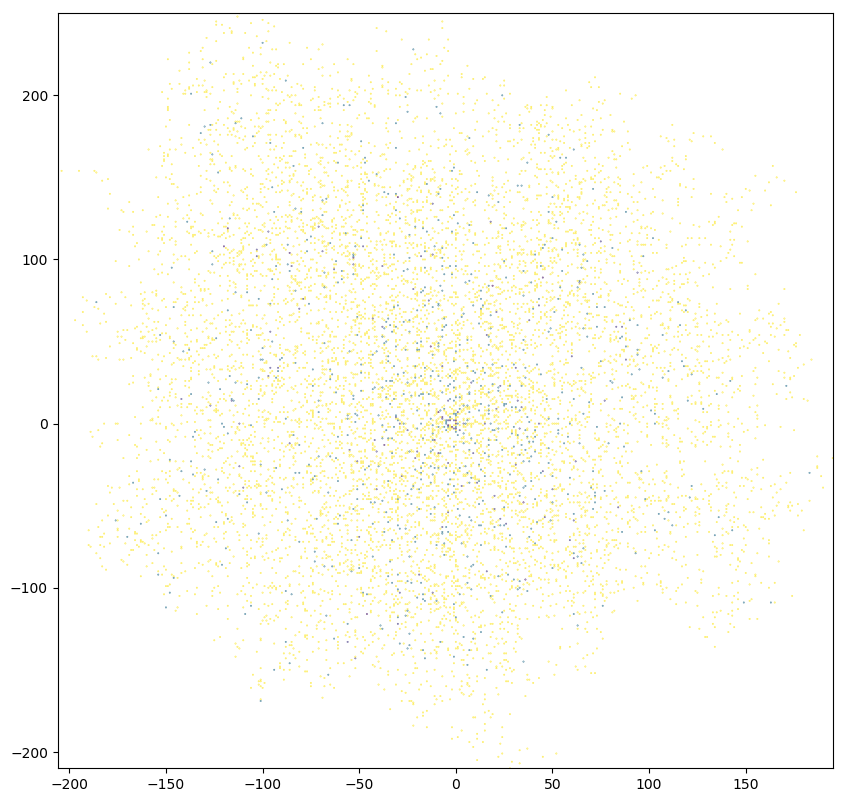

In [9]:
popindex2.paint()

[[500,
  1000,
  1500,
  2000,
  2500,
  3000,
  3500,
  4000,
  4500,
  5000,
  5500,
  6000,
  6500,
  7000,
  7500,
  8000,
  8500,
  9000,
  9500,
  10000,
  10500,
  11000,
  11500,
  12000,
  12500,
  13000,
  13500,
  14000,
  14500,
  15000,
  15500,
  16000,
  16500,
  17000,
  17500,
  18000,
  18500,
  19000,
  19500],
 [2.450980392156863,
  1.949317738791423,
  1.7964071856287425,
  1.7108639863130881,
  1.665556295802798,
  1.670378619153675,
  1.6786570743405276,
  1.6611295681063123,
  1.6660496112550907,
  1.6644474034620507,
  1.675296984465428,
  1.682085786375105,
  1.6817593790426908,
  1.6794625719769674,
  1.6793551276309897,
  1.678556441460344,
  1.6825019794140934,
  1.6784781797836628,
  1.6802263883975945,
  1.6818028927009754,
  1.6856638304703804,
  1.6907470027666769,
  1.6969160395455216,
  1.6982734220209454,
  1.7009116886651245,
  1.7044709584371311,
  1.7056222362602653,
  1.706900755913192,
  1.7107126002831525,
  1.7146776406035664,
  1.715170963815

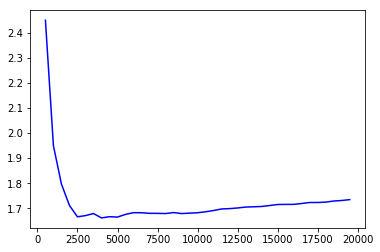

In [89]:
popindex2.curveDensity(500)

In [ ]:
# 2d0.d0=10

In [29]:
demo2 = city(4,0.2,10000,r0 = 3)
popindex2 = demo2.step()

2 3 2
2 3 3
4 3 4
4 3 5
4 3 6
4 3 7
5 3 8
5 3 9
5 3 10
5 3 11
5 3 12
5 3 13
6 3 14
6 3 15
6 3 16
8 3 17
8 3 18
8 3 19
8 3 20
8 3 21
8 3 22
8 3 23
8 3 24
8 3 25
8 3 26
8 3 27
8 3 28
8 3 29
8 3 30
10 3 31
10 3 32
10 3 33
10 3 34
10 3 35
10 3 36
10 3 37
10 3 38
10 3 39
10 3 40
10 3 41
10 3 42
10 3 43
10 3 44
11 3 45
11 3 46
11 3 47
11 3 48
11 3 49
11 3 50
11 3 51
11 3 52
11 3 53
11 3 54
11 3 55
11 3 56
11 3 57
11 3 58
11 3 59
11 3 60
11 3 61
11 3 62
11 3 63
13 3 64
13 3 65
13 3 66
13 3 67
13 3 68
13 3 69
13 3 70
13 3 71
13 3 72
13 3 73
13 3 74
13 3 75
13 3 76
14 3 77
14 3 78
14 3 79
14 3 80
14 3 81
14 3 82
14 3 83
14 3 84
14 3 85
14 3 86
14 3 87
14 3 88
15 3 89
15 3 90
15 3 91
15 3 92
15 3 93
15 3 94
15 3 95
15 3 96
15 3 97
15 3 98
17 3 99
17 3 100
17 3 101
17 3 102
17 3 103
17 3 104
17 3 105
17 3 106
17 3 107
17 3 108
17 3 109
17 3 110
17 3 111
17 3 112
17 3 113
17 3 114
17 3 115
17 3 116
17 3 117
17 3 118
17 3 119
17 3 120
17 3 121
17 3 122
17 3 123
17 3 124
17 3 125
17 3 126
17 3 127
1

181 12 979
181 12 980
181 12 981
181 12 982
181 12 983
181 12 984
181 12 985
181 12 986
181 12 987
181 12 988
181 12 989
181 12 990
181 12 991
181 12 992
181 12 993
181 12 99

limit_output extension: Maximum message size of 10000 exceeded with 11707 characters

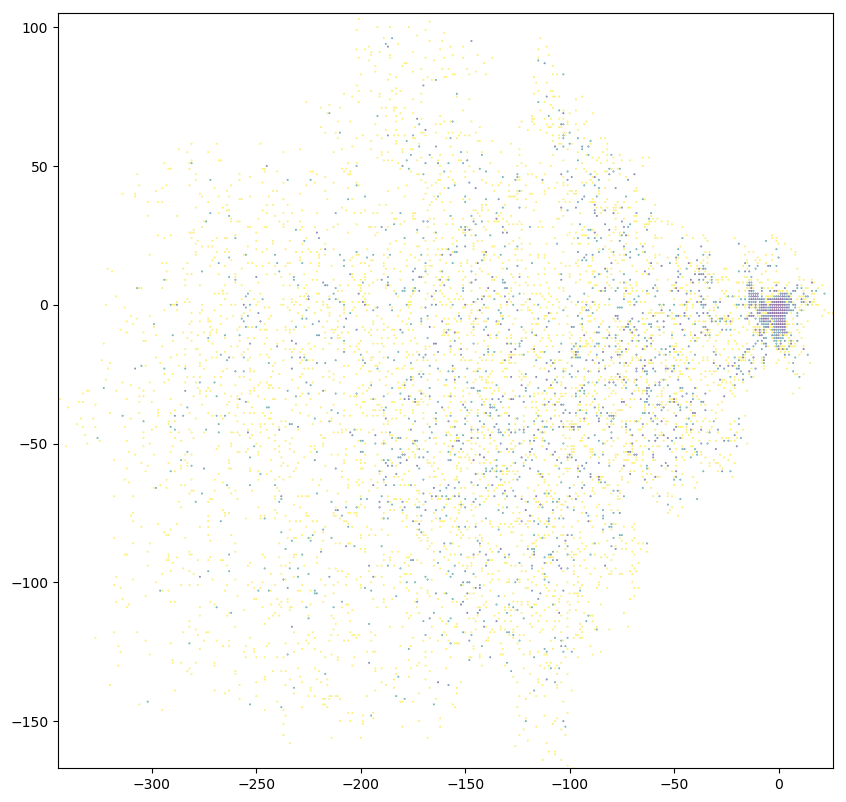

In [30]:
popindex2.paint()

In [ ]:
## 3d0.d0=10

In [31]:
demo2 = city(4,0.2,10000,r0 = 3)
popindex2 = demo2.step()

2 3 2
3 3 3
5 3 4
6 3 5
6 3 6
6 3 7
6 3 8
6 3 9
6 3 10
6 3 11
6 3 12
6 3 13
6 3 14
6 3 15
8 3 16
8 3 17
8 3 18
8 3 19
8 3 20
8 3 21
8 3 22
8 3 23
8 3 24
8 3 25
8 3 26
8 3 27
8 3 28
8 3 29
8 3 30
8 3 31
8 3 32
8 3 33
8 3 34
10 3 35
10 3 36
10 3 37
10 3 38
10 3 39
10 3 40
10 3 41
10 3 42
10 3 43
10 3 44
10 3 45
10 3 46
10 3 47
10 3 48
12 3 49
12 3 50
13 3 51
13 3 52
13 3 53
13 3 54
13 3 55
13 3 56
13 3 57
13 3 58
13 3 59
13 3 60
13 3 61
13 3 62
13 3 63
13 3 64
13 3 65
13 3 66
13 3 67
13 3 68
13 3 69
13 3 70
13 3 71
13 3 72
13 3 73
13 3 74
13 3 75
13 3 76
13 3 77
13 3 78
13 3 79
13 3 80
13 3 81
13 3 82
13 3 83
13 3 84
13 3 85
13 3 86
13 3 87
13 3 88
13 3 89
13 3 90
13 3 91
13 3 92
13 3 93
13 3 94
13 3 95
13 3 96
13 3 97
13 3 98
13 3 99
13 3 100
13 3 101
13 3 102
13 3 103
13 3 104
13 3 105
13 3 106
13 3 107
13 3 108
13 3 109
13 3 110
13 3 111
13 3 112
13 3 113
13 3 114
13 3 115
13 3 116
13 3 117
13 3 118
13 3 119
13 3 120
13 3 121
13 3 122
13 3 123
13 3 124
13 3 125
13 3 126
13 3 127
13 3 

181 12 913
181 12 914
181 12 915
181 12 916
181 12 917
181 12 918
181 12 919
181 12 920
181 12 921
181 12 922
181 12 923
181 12 924
181 12 925
181 12 926
181 12 927
188 12 928
188 12 929
188 12 930
188 12 931
188 12 932
188 12 933
188 12 934
188 12 935
188 12 936
188 12 937
188 12 938
188 12 939
188 12 940
188 12 941
188 12 942
188 12 943
188 12 944
188 12 945
188 12 946
188 12 947
188 12 948
188 12 949
188 12 950
188 12 951
188 12 952
188 12 953
188 12 954
188 12 955
188 12 956
188 12 957
188 12 958
188 12 959
188 12 960
188 12 961
188 12 962
188 12 963
188 12 964
188 12 965
188 12 966
188 12 967
188 12 968
188 12 969
188 12 970
188 12 971
188 12 972
188 12 973
188 12 974
188 12 975
188 12 976
188 12 977
188 12 978
188 12 979
188 12 980
188 12 981
188 12 982
188 12 983
188 12 984
188 12 9

limit_output extension: Maximum message size of 10000 exceeded with 10913 characters

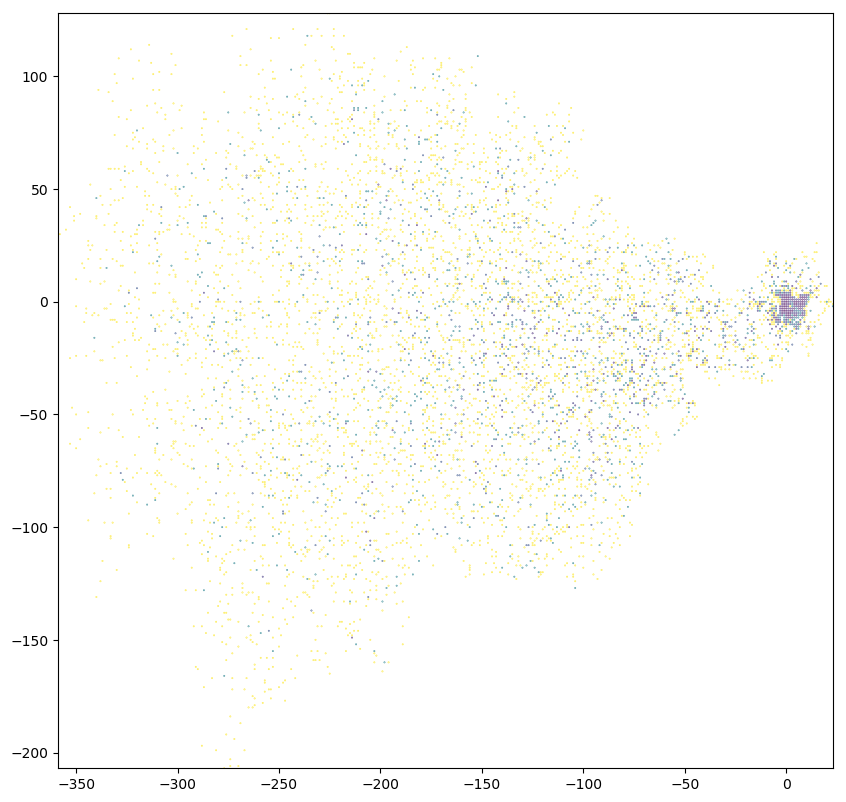

In [32]:
popindex2.paint()

### 2d0 d0 = 10 c= 0.1

In [44]:
demo2 = city(4,0.1,10000,r0 = 3)
popindex2 = demo2.step()

1 3 2
2 3 3
5 3 4
5 3 5
5 3 6
5 3 7
5 3 8
6 3 9
7 3 10
7 3 11
9 3 12
9 3 13
9 3 14
9 3 15
11 3 16
11 3 17
11 3 18
11 3 19
11 3 20
11 3 21
11 3 22
11 3 23
11 3 24
11 3 25
11 3 26
11 3 27
11 3 28
11 3 29
11 3 30
11 3 31
11 3 32
11 3 33
11 3 34
11 3 35
11 3 36
11 3 37
11 3 38
11 3 39
11 3 40
11 3 41
11 3 42
11 3 43
11 3 44
11 3 45
11 3 46
11 3 47
11 3 48
11 3 49
11 3 50
11 3 51
11 3 52
11 3 53
11 3 54
11 3 55
11 3 56
11 3 57
11 3 58
11 3 59
11 3 60
11 3 61
11 3 62
11 3 63
11 3 64
11 3 65
11 3 66
11 3 67
11 3 68
11 3 69
11 3 70
11 3 71
11 3 72
11 3 73
11 3 74
11 3 75
11 3 76
11 3 77
11 3 78
11 3 79
11 3 80
12 3 81
12 3 82
12 3 83
12 3 84
12 3 85
12 3 86
15 3 87
15 3 88
15 3 89
15 3 90
15 3 91
15 3 92
15 3 93
15 3 94
15 3 95
15 3 96
15 3 97
15 3 98
15 3 99
15 3 100
15 3 101
15 3 102
15 3 103
15 3 104
15 3 105
15 3 106
15 3 107
15 3 108
15 3 109
15 3 110
15 3 111
15 3 112
15 3 113
15 3 114
15 3 115
15 3 116
15 3 117
15 3 118
15 3 119
15 3 120
15 3 121
15 3 122
15 3 123
15 3 124
15 3 125
15 3

limit_output extension: Maximum message size of 10000 exceeded with 10202 characters

##### popindex2.paint()

### d = d0 =20 c =0.2 delta =10

In [59]:
demo2 = city(4,0.2,10000,r0 = 3)
popindex2 = demo2.step()

2 3 2
2 3 3
2 3 4
2 3 5
2 3 6
2 3 7
5 3 8
5 3 9
5 3 10
5 3 11
5 3 12
5 3 13
5 3 14
5 3 15
5 3 16
5 3 17
7 3 18
7 3 19
7 3 20
7 3 21
7 3 22
7 3 23
7 3 24
7 3 25
10 3 26
10 3 27
10 3 28
10 3 29
10 3 30
10 3 31
10 3 32
10 3 33
10 3 34
10 3 35
10 3 36
11 3 37
11 3 38
11 3 39
11 3 40
11 3 41
11 3 42
11 3 43
11 3 44
11 3 45
11 3 46
11 3 47
11 3 48
11 3 49
11 3 50
11 3 51
11 3 52
11 3 53
11 3 54
11 3 55
11 3 56
11 3 57
11 3 58
11 3 59
11 3 60
11 3 61
11 3 62
11 3 63
11 3 64
11 3 65
11 3 66
11 3 67
11 3 68
11 3 69
11 3 70
11 3 71
11 3 72
11 3 73
11 3 74
11 3 75
11 3 76
11 3 77
11 3 78
11 3 79
11 3 80
11 3 81
11 3 82
11 3 83
11 3 84
11 3 85
11 3 86
11 3 87
11 3 88
11 3 89
11 3 90
11 3 91
11 3 92
11 3 93
11 3 94
11 3 95
11 3 96
11 3 97
11 3 98
11 3 99
11 3 100
11 3 101
11 3 102
13 3 103
13 3 104
13 3 105
13 3 106
13 3 107
13 3 108
13 3 109
13 3 110
13 3 111
13 3 112
13 3 113
13 3 114
13 3 115
13 3 116
13 3 117
13 3 118
13 3 119
13 3 120
13 3 121
13 3 122
13 3 123
13 3 124
13 3 125
13 3 126
13 3 

160 13.0 763
160 13.0 764
160 13.0 765
160 13.0 766
160 13.0 767
160 13.0 768
160 13.0 769
160 13.0 770
160 13.0 771
160 13.0 772
160 13.0 773
160 13.0 774
160 13.0 775
160 13.0 776
160 13.0 777
160 13.0 778
160 13.0 779
160 13.0 780
160 13.0 781
160 13.0 782
166 13.0 783
166 13.0 784
166 13.0 785
166 13.0 786
166 13.0 787
166 13.0 788
166 13.0 789
166 13.0 790
166 13.0 791
166 13.0 792
166 13.0 793
168 13.0 794
168 13.0 795
168 13.0 796
168 13.0 797
168 13.0 798
168 13.0 799
168 13.0 800
168 13.0 801
168 13.0 802
168 13.0 803
168 13.0 804
168 13.0 805
168 13.0 806
168 13.0 807
168 13.0 808
168 13.0 809
168 13.0 810
168 13.0 811
168 13.0 812
168 13.0 813
168 13.0 814
168 13.0 815
168 13.0 816
168 13.0 817
168 13.0 818
168 13.0 819
168 13.0 820
168 13.0 821
168 13.0 822
168 13.0 823
168 13.0 824
168 13.0 825
168 13.0 826
168 13.0 827
168 13.0 828
168 13.0 829
168 13.0 830
168 13.0 831
168 13.0 832
168 13.0 833
168 13.0 834
168 13.0 835
168 13.0 836
168 13.0 837
168 13.0 838
168 13.0 839

limit_output extension: Maximum message size of 10000 exceeded with 10058 characters

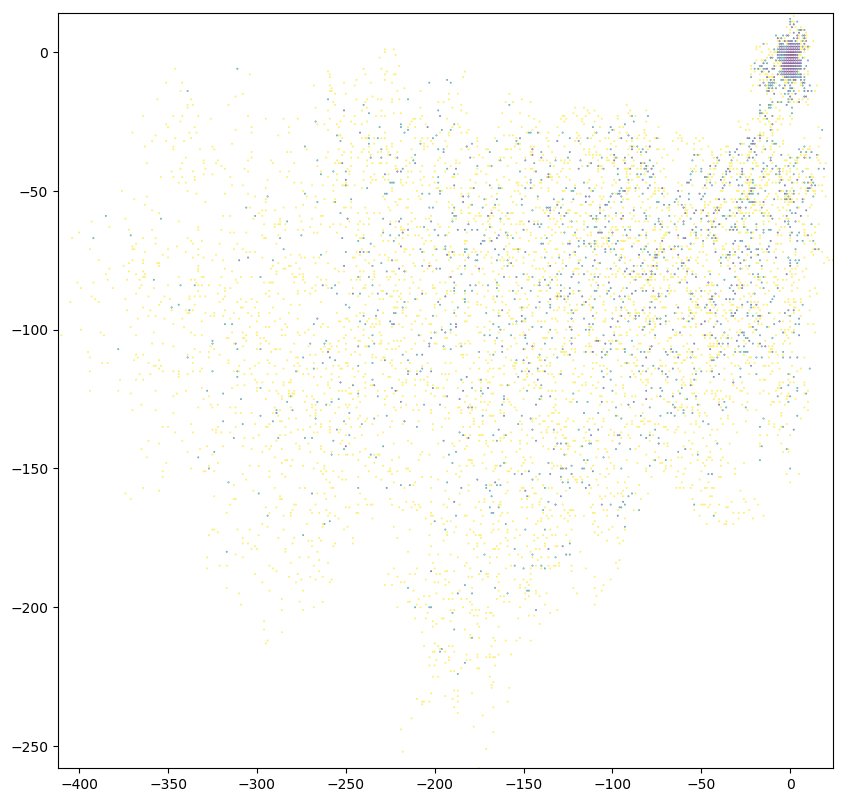

In [60]:
popindex2.paint()

### 分段rd

In [125]:
demo2 = city(4,0.2,10000,r0 = 3)
popindex2 = demo2.step()

2 3 2
2 3 3
2 3 4
2 3 5
3 3 6
3 3 7
4 3 8
4 3 9
4 3 10
5 3 11
5 3 12
5 3 13
5 3 14
5 3 15
5 3 16
5 3 17
6 3 18
6 3 19
6 3 20
7 3 21
7 3 22
8 3 23
8 3 24
8 3 25
8 3 26
8 3 27
8 3 28
8 3 29
8 3 30
8 3 31
8 3 32
8 3 33
8 3 34
8 3 35
8 3 36
8 3 37
8 3 38
8 3 39
8 3 40
8 3 41
8 3 42
8 3 43
8 3 44
8 3 45
8 3 46
8 3 47
8 3 48
8 3 49
8 3 50
8 3 51
8 3 52
8 3 53
10 3 54
13 3 55
13 3 56
13 3 57
13 3 58
13 3 59
13 3 60
13 3 61
13 3 62
13 3 63
13 3 64
13 3 65
13 3 66
13 3 67
13 3 68
13 3 69
13 3 70
13 3 71
13 3 72
13 3 73
13 3 74
13 3 75
13 3 76
13 3 77
13 3 78
13 3 79
13 3 80
13 3 81
13 3 82
13 3 83
13 3 84
13 3 85
13 3 86
13 3 87
13 3 88
13 3 89
13 3 90
13 3 91
13 3 92
13 3 93
16 3 94
16 3 95
16 3 96
16 3 97
16 3 98
16 3 99
16 3 100
16 3 101
16 3 102
16 3 103
16 3 104
16 3 105
16 3 106
16 3 107
16 3 108
16 3 109
16 3 110
16 3 111
16 3 112
16 3 113
16 3 114
16 3 115
16 3 116
16 3 117
16 3 118
16 3 119
16 3 120
17 3 121
17 3 122
17 3 123
17 3 124
17 3 125
17 3 126
17 3 127
17 3 128
17 3 129
17 3 1

100 13 986
100 13 987
100 13 988
100 13 989
100 13 990
100 13 991
100 13 992
100 13 993
100 13 994
100 13 995
100 13 996
100 13 997
100 13 998
100 13 999
100 13 1000
100 13 1001
100 13 1002
100 13 1003
100 13 1004
100 13 1005
100 13 1006
100 13 

limit_output extension: Maximum message size of 10000 exceeded with 12348 characters

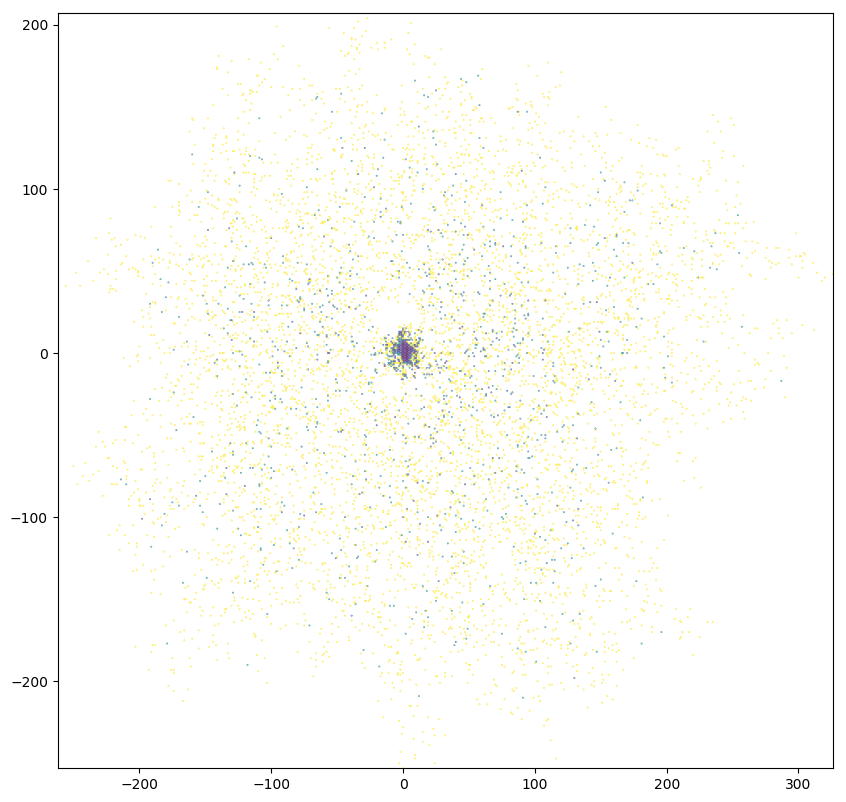

In [126]:
popindex2.paint()

### 分段2

In [127]:
demo2 = city(4,0.2,10000,r0 = 3)
popindex2 = demo2.step()

0 3 2
1 3 3
1 3 4
1 3 5
1 3 6
3 3 7
3 3 8
4 3 9
4 3 10
4 3 11
4 3 12
4 3 13
4 3 14
4 3 15
4 3 16
4 3 17
4 3 18
5 3 19
5 3 20
5 3 21
5 3 22
5 3 23
5 3 24
5 3 25
5 3 26
7 3 27
7 3 28
7 3 29
7 3 30
7 3 31
7 3 32
7 3 33
9 3 34
9 3 35
9 3 36
9 3 37
9 3 38
9 3 39
9 3 40
9 3 41
9 3 42
9 3 43
9 3 44
9 3 45
9 3 46
9 3 47
9 3 48
9 3 49
14 3 50
14 3 51
14 3 52
14 3 53
14 3 54
14 3 55
14 3 56
14 3 57
14 3 58
14 3 59
14 3 60
14 3 61
14 3 62
14 3 63
14 3 64
14 3 65
14 3 66
14 3 67
14 3 68
14 3 69
14 3 70
14 3 71
14 3 72
14 3 73
14 3 74
14 3 75
14 3 76
14 3 77
14 3 78
14 3 79
14 3 80
14 3 81
14 3 82
14 3 83
14 3 84
14 3 85
14 3 86
14 3 87
14 3 88
14 3 89
14 3 90
14 3 91
14 3 92
14 3 93
14 3 94
14 3 95
14 3 96
14 3 97
14 3 98
14 3 99
14 3 100
14 3 101
14 3 102
14 3 103
14 3 104
14 3 105
14 3 106
14 3 107
14 3 108
14 3 109
14 3 110
14 3 111
14 3 112
14 3 113
14 3 114
14 3 115
14 3 116
14 3 117
14 3 118
14 3 119
14 3 120
14 3 121
14 3 122
14 3 123
15 3 124
15 3 125
15 3 126
15 3 127
15 3 128
15 3 129
15

limit_output extension: Maximum message size of 10000 exceeded with 10948 characters

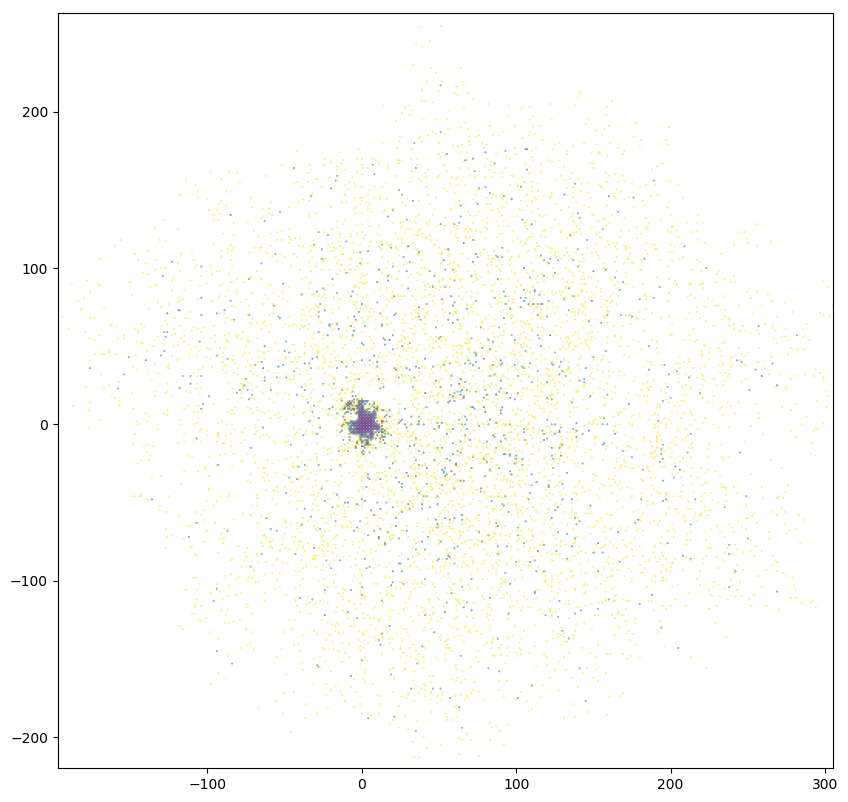

In [128]:
popindex2.paint()

[[400,
  800,
  1200,
  1600,
  2000,
  2400,
  2800,
  3200,
  3600,
  4000,
  4400,
  4800,
  5200,
  5600,
  6000,
  6400,
  6800,
  7200,
  7600,
  8000,
  8400,
  8800,
  9200,
  9600],
 [2.3121387283236996,
  2.7874564459930316,
  3.260869565217391,
  3.0828516377649327,
  2.73224043715847,
  2.373887240356083,
  2.165506573859242,
  2.01765447667087,
  1.9037546271813854,
  1.817355747387551,
  1.7592962814874051,
  1.703940362087327,
  1.6666666666666667,
  1.6331291921843103,
  1.6004267804747934,
  1.5818091942659416,
  1.5642972164711295,
  1.5483870967741935,
  1.5350434255705918,
  1.5240998285387692,
  1.511879049676026,
  1.5014502644599899,
  1.4930217461863031,
  1.4830835779391318]]

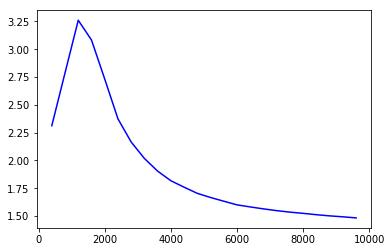

In [129]:
popindex2.curveDensity(400)

## 1

In [30]:
demo = city(4,0.2,5000,fx,r0 = 3)
popindex = demo.step()


1 3 2
3 3 3
3 3 4
3 3 5
3 3 6
5 3 7
7 3 8
7 3 9
7 3 10
7 3 11
7 3 12
7 3 13
7 3 14
7 3 15
7 3 16
7 3 17
7 3 18
7 3 19
7 3 20
7 3 21
7 3 22
7 3 23
7 3 24
7 3 25
7 3 26
9 3 27
9 3 28
9 3 29
9 3 30
9 3 31
9 3 32
9 3 33
9 3 34
9 3 35
9 3 36
9 3 37
9 3 38
9 3 39
9 3 40
9 3 41
9 3 42
9 3 43
9 3 44
9 3 45
9 3 46
9 3 47
9 3 48
9 3 49
9 3 50
9 3 51
9 3 52
9 3 53
9 3 54
10 3 55
10 3 56
10 3 57
10 3 58
10 3 59
10 3 60
10 3 61
10 3 62
10 3 63
10 3 64
10 3 65
10 3 66
10 3 67
10 3 68
10 3 69
10 3 70
10 3 71
10 3 72
10 3 73
10 3 74
10 3 75
13 3 76
13 3 77
13 3 78
13 3 79
13 3 80
13 3 81
13 3 82
13 3 83
13 3 84
13 3 85
13 3 86
13 3 87
13 3 88
13 3 89
13 3 90
13 3 91
13 3 92
13 3 93
13 3 94
13 3 95
13 3 96
13 3 97
13 3 98
13 3 99
13 3 100
13 3 101
13 3 102
13 3 103
13 3 104
13 3 105
13 3 106
13 3 107
13 3 108
13 3 109
13 3 110
13 3 111
13 3 112
13 3 113
13 3 114
13 3 115
13 3 116
13 3 117
13 3 118
13 3 119
14 3 120
14 3 121
14 3 122
14 3 123
14 3 124
14 3 125
14 3 126
14 3 127
14 3 128
14 3 129
14 3 13

24 3 1074
24 3 1075
24 3 1076
24 3 1077
24 3 1078
24 3 1079
24 3 1080
24 3 1081
24 3 1082
24 3 1083
24 3 1084
24 3 1085
24 3 1086
24 3 1087
24 3 1088
24 3 1089
24 3 1090
24 3 1091
24 3 1092
24 3 1093
24 3 1094
24 3 1095
24 3 1096
24 3 1097
24 3 1098
24 3 1099
24 3 1100
24 3 1101
24 3 1102
24 3 1103
24 3 1104
24 3 1105
24 3 1106
24 3 1107
24 3 1108
24 3 1109
24 3 1110
24 3 1111
24 3 1112
24 3 1113
24 3 1114
24 3 1115
24 3 1116
24 3 1117
24 3 1118
24 3 1119
24 3 1120
24 3 1121
24 3 1122
24 3 1123
24 3 1124
24 3 1125
24 3 1126
24 3 1127
24 3 1128
24 3 1129
24 3 1130
24 3 1131
24 3 1132
24 3 1133
24 3 1134
24 3 1135
24 3 1136
24 3 1137
24 3 1138
24 3 1139
24 3 1140
24 3 1141
24 3 1142
24 3 1143
24 3 1144
24 3 1145
24 3 1146
24 3 1147
24 3 1148
24 3 1149
24 3 1150
24 3 1151
24 3 1152
24 3 1153
24 3 1154
24 3 1155
24 3 1156
24 3 1157
24 3 1158
24 3 1159
24 3 1160
24 3 1161
24 3 1162
24 3 1163
24 3 1164
24 3 1165
24 3 1166
24 3 1167
24 3 1168
24 3 1169
24 3 1170
24 3 1171
24 3 1172
24 3 1173


24 3 1907
24 3 1908
24 3 1909
24 3 1910
24 3 1911
24 3 1912
24 3 1913
24 3 1914
24 3 1915
24 3 1916
24 3 1917
24 3 1918
24 3 1919
24 3 1920
24 3 1921
24 3 1922
24 3 1923
25 3 1924
25 3 1925
25 3 1926
25 3 1927
25 3 1928
25 3 1929
25 3 1930
25 3 1931
25 3 1932
25 3 1933
25 3 1934
25 3 1935
25 3 1936
25 3 1937
25 3 1938
25 3 1939
25 3 1940
25 3 1941
25 3 1942
25 3 1943
25 3 1944
25 3 1945
25 3 1946
25 3 1947
25 3 1948
25 3 1949
25 3 1950
25 3 1951
25 3 1952
25 3 1953
25 3 1954
25 3 1955
25 3 1956
25 3 1957
25 3 1958
25 3 1959
25 3 1960
25 3 1961
25 3 1962
25 3 1963
25 3 1964
25 3 1965
27 3 1966
27 3 1967
27 3 1968
27 3 1969
27 3 1970
27 3 1971
27 3 1972
27 3 1973
27 3 1974
27 3 1975
27 3 1976
27 3 1977
27 3 1978
27 3 1979
27 3 1980
27 3 1981
27 3 1982
27 3 1983
27 3 1984
27 3 1985
27 3 1986
27 3 1987
27 3 1988
27 3 1989
27 3 1990
27 3 1991
27 3 1992
27 3 1993
27 3 1994
27 3 1995
27 3 1996
27 3 1997
27 3 1998
27 3 1999
27 3 2000
27 3 2001
27 3 2002
27 3 2003
27 3 2004
27 3 2005
27 3 2006


28 4 2739
28 4 2740
28 4 2741
28 4 2742
28 4 2743
28 4 2744
28 4 2745
28 4 2746
28 4 2747
28 4 2748
28 4 2749
28 4 2750
28 4 2751
28 4 2752
28 4 2753
28 4 2754
28 4 2755
28 4 2756
28 4 2757
28 4 2758
28 4 2759
28 4 2760
28 4 2761
28 4 2762
28 4 2763
28 4 2764
28 4 2765
28 4 2766
28 4 2767
28 4 2768
28 4 2769
28 4 2770
28 4 2771
28 4 2772
28 4 2773
28 4 2774
28 4 2775
28 4 2776
28 4 2777
28 4 2778
28 4 2779
28 4 2780
28 4 2781
28 4 2782
28 4 2783
28 4 2784
28 4 2785
28 4 2786
28 4 2787
28 4 2788
28 4 2789
28 4 2790
28 4 2791
28 4 2792
28 4 2793
28 4 2794
28 4 2795
28 4 2796
28 4 2797
28 4 2798
28 4 2799
28 4 2800
28 4 2801
28 4 2802
28 4 2803
28 4 2804
28 4 2805
28 4 2806
28 4 2807
28 4 2808
28 4 2809
28 4 2810
28 4 2811
28 4 2812
28 4 2813
28 4 2814
28 4 2815
28 4 2816
28 4 2817
28 4 2818
28 4 2819
28 4 2820
28 4 2821
28 4 2822
28 4 2823
28 4 2824
28 4 2825
28 4 2826
28 4 2827
28 4 2828
28 4 2829
28 4 2830
28 4 2831
28 4 2832
28 4 2833
28 4 2834
28 4 2835
28 4 2836
28 4 2837
28 4 2838


64 12 3572
64 12 3573
64 12 3574
64 12 3575
64 12 3576
64 12 3577
64 12 3578
64 12 3579
64 12 3580
64 12 3581
64 12 3582
64 12 3583
64 12 3584
64 12 3585
64 12 3586
64 12 3587
64 12 3588
64 12 3589
64 12 3590
64 12 3591
64 12 3592
64 12 3593
64 12 3594
64 12 3595
64 12 3596
64 12 3597
64 12 3598
64 12 3599
64 12 3600
64 12 3601
64 12 3602
64 12 3603
64 12 3604
64 12 3605
64 12 3606
64 12 3607
64 12 3608
64 12 3609
64 12 3610
64 12 3611
64 12 3612
64 12 3613
64 12 3614
64 12 3615
64 12 3616
64 12 3617
64 12 3618
64 12 3619
64 12 3620
64 12 3621
64 12 3622
64 12 3623
64 12 3624
64 12 3625
64 12 3626
64 12 3627
64 12 3628
64 12 3629
64 12 3630
64 12 3631
74 13 3632
74 13 3633
74 13 3634
74 13 3635
74 13 3636
74 13 3637
74 13 3638
74 13 3639
74 13 3640
74 13 3641
74 13 3642
74 13 3643
74 13 3644
74 13 3645
74 13 3646
74 13 3647
74 13 3648
74 13 3649
74 13 3650
81 13 3651
81 13 3652
81 13 3653
81 13 3654
81 13 3655
81 13 3656
81 13 3657
81 13 3658
81 13 3659
81 13 3660
81 13 3661
81 13 3662

139 13 4404
139 13 4405
139 13 4406
139 13 4407
139 13 4408
139 13 4409
139 13 4410
139 13 4411
139 13 4412
139 13 4413
139 13 4414
139 13 4415
139 13 4416
139 13 4417
139 13 4418
139 13 4419
139 13 4420
139 13 4421
139 13 4422
139 13 4423
139 13 4424
139 13 4425
139 13 4426
139 13 4427
139 13 4428
139 13 4429
139 13 4430
139 13 4431
139 13 4432
139 13 4433
139 13 4434
139 13 4435
139 13 4436
139 13 4437
139 13 4438
139 13 4439
159 13 4440
159 13 4441
159 13 4442
159 13 4443
159 13 4444
159 13 4445
159 13 4446
159 13 4447
159 13 4448
159 13 4449
159 13 4450
159 13 4451
159 13 4452
159 13 4453
159 13 4454
159 13 4455
159 13 4456
159 13 4457
159 13 4458
159 13 4459
159 13 4460
159 13 4461
159 13 4462
159 13 4463
159 13 4464
159 13 4465
159 13 4466
159 13 4467
159 13 4468
159 13 4469
159 13 4470
159 13 4471
159 13 4472
159 13 4473
159 13 4474
159 13 4475
159 13 4476
159 13 4477
159 13 4478
159 13 4479
159 13 4480
159 13 4481
159 13 4482
159 13 4483
159 13 4484
159 13 4485
159 13 4486
159 

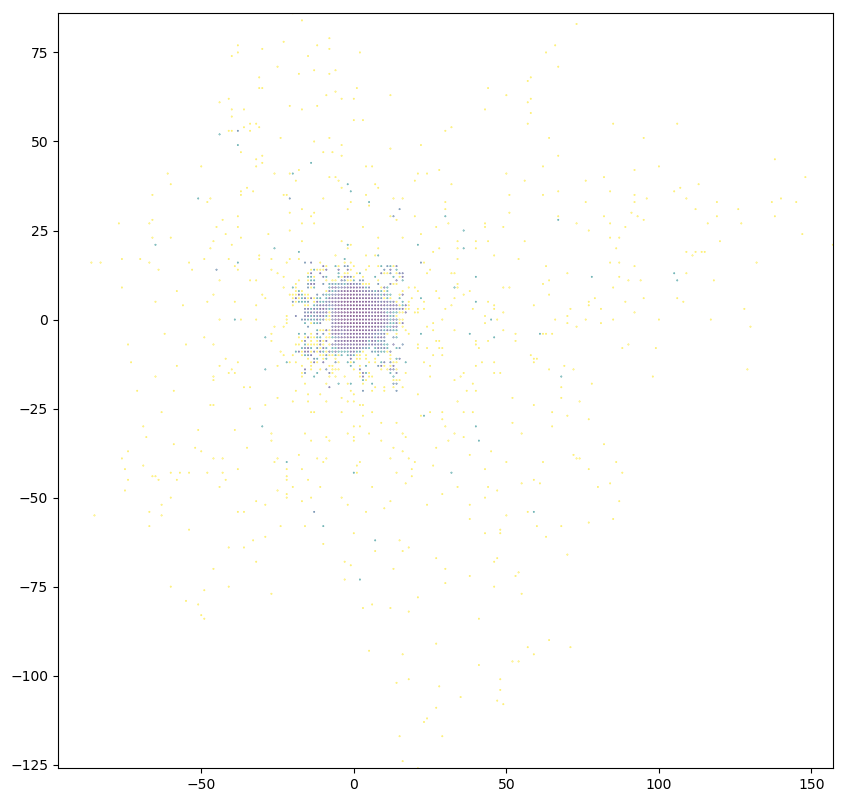

In [31]:
popindex.paint()

In [8]:
popindex[0:1000].density()

3.4246575342465753

In [9]:
popindex.density()

2.0080321285140563

[0.8560078986472568, 3.938011031300664]

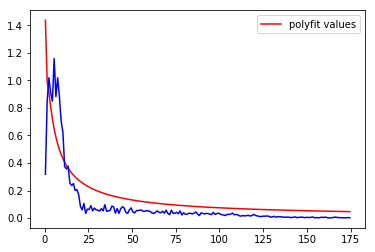

In [10]:
landindex = popindex.landCoor()
landindex.curveFit(1)

[1.0649275004651166, 19.188034384026132]

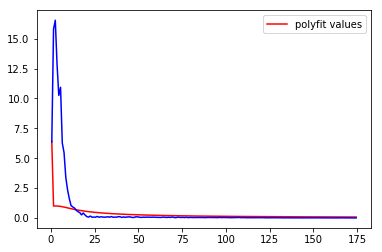

In [11]:
popindex.curveFit(1)

## 2 

In [13]:
demo = city(4,0.2,10000,radius = 3)
popindex = demo.step()

1 3 2
1 3 3
1 3 4
1 3 5
1 3 6
1 3 7
2 3 8
4 3 9
4 3 10
4 3 11
4 3 12
4 3 13
5 3 14
5 3 15
5 3 16
7 3 17
7 3 18
7 3 19
7 3 20
7 3 21
7 3 22
7 3 23
7 3 24
7 3 25
7 3 26
7 3 27
7 3 28
7 3 29
7 3 30
7 3 31
7 3 32
7 3 33
7 3 34
7 3 35
7 3 36
10 3 37
10 3 38
10 3 39
10 3 40
10 3 41
10 3 42
10 3 43
10 3 44
10 3 45
10 3 46
10 3 47
10 3 48
10 3 49
10 3 50
11 3 51
11 3 52
11 3 53
11 3 54
11 3 55
11 3 56
11 3 57
11 3 58
11 3 59
11 3 60
11 3 61
11 3 62
11 3 63
11 3 64
11 3 65
11 3 66
11 3 67
11 3 68
11 3 69
11 3 70
11 3 71
15 3 72
15 3 73
15 3 74
15 3 75
15 3 76
15 3 77
15 3 78
15 3 79
15 3 80
16 3 81
16 3 82
16 3 83
16 3 84
16 3 85
16 3 86
16 3 87
16 3 88
16 3 89
16 3 90
16 3 91
16 3 92
16 3 93
16 3 94
16 3 95
16 3 96
16 3 97
16 3 98
16 3 99
16 3 100
16 3 101
16 3 102
16 3 103
16 3 104
16 3 105
16 3 106
16 3 107
16 3 108
16 3 109
16 3 110
16 3 111
16 3 112
16 3 113
16 3 114
16 3 115
16 3 116
16 3 117
16 3 118
16 3 119
16 3 120
16 3 121
16 3 122
16 3 123
16 3 124
16 3 125
16 3 126
16 3 127
16 3 12

46 12 960
46 12 961
46 12 962
46 12 963
46 12 964
46 12 965
46 12 966
49 12 967
49 12 968
49 12 969
49 12 970
49 12 971
49 12 972
49 12 973
49 12 974
50 12 975
60 12 976
60 12 977
60 12 978
60 12 979
60 12 980
60 12 981
60 12 982
60 12 983
60 12 984
60 12 985
60 12 986
64 12 987
64 12 988
64 12 989
64 12 990
64 12 991
64 12 992
64 12 993
64 12 994
64 12 995
64 12 996
64 12 997
64 12 998
64 12 999
64 12 1000
64 12 1001
64 12 1002
64 12 1003
64 12 1004
64 12 1005
64 12 1006
64 12 1007
64 12 1008
64 12 1009
64 12 1010
64 12 1011
64 12 1012
64 12 1013
64 12 1014
64 12 1015
64 12 1016
69 13 1017
69 13 1018
69 13 1019
69 13 1020
69 13 1021
69 13 1022
69 13 1023
69 13 1024
69 13 1025
69 13 1026
69 13 1027
69 13 1028
69 13 1029
69 13 1030
69 13 1031
69 13 1032
69 13 1033
69 13 1034
69 13 1035
69 13 1036
69 13 1037
69 13 1038
69 13 1039
69 13 1040
75 13 1041
75 13 1042
75 13 1043
75 13 1044
75 13 1045
75 13 1046
75 13 1047
75 13 1048
75 13 1049
75 13 1050
75 13 1051
75 13 1052
75 13 1053
75 13 

145 13 1793
145 13 1794
145 13 1795
145 13 1796
145 13 1797
145 13 1798
145 13 1799
145 13 1800
145 13 1801
145 13 1802
145 13 1803
145 13 1804
145 13 1805
145 13 1806
145 13 1807
145 13 1808
145 13 1809
145 13 1810
145 13 1811
145 13 1812
145 13 1813
145 13 1814
145 13 1815
145 13 1816
145 13 1817
145 13 1818
145 13 1819
145 13 1820
148 13 1821
148 13 1822
148 13 1823
148 13 1824
148 13 1825
148 13 1826
148 13 1827
148 13 1828
148 13 1829
148 13 1830
148 13 1831
148 13 1832
148 13 1833
148 13 1834
148 13 1835
148 13 1836
148 13 1837
148 13 1838
148 13 1839
148 13 1840
148 13 1841
148 13 1842
148 13 1843
148 13 1844
148 13 1845
148 13 1846
148 13 1847
148 13 1848
148 13 1849
148 13 1850
148 13 1851
148 13 1852
148 13 1853
148 13 1854
148 13 1855
148 13 1856
148 13 1857
148 13 1858
148 13 1859
156 13 1860
156 13 1861
156 13 1862
156 13 1863
156 13 1864
156 13 1865
156 13 1866
156 13 1867
156 13 1868
156 13 1869
156 13 1870
156 13 1871
156 13 1872
156 13 1873
156 13 1874
156 13 1875
156 

217 13 2625
217 13 2626
217 13 2627
217 13 2628
217 13 2629
217 13 2630
217 13 2631
217 13 2632
217 13 2633
217 13 2634
217 13 2635
217 13 2636
217 13 2637
217 13 2638
217 13 2639
217 13 2640
217 13 2641
217 13 2642
217 13 2643
217 13 2644
217 13 2645
217 13 2646
217 13 2647
217 13 2648
217 13 2649
217 13 2650
217 13 2651
217 13 2652
217 13 2653
217 13 2654
217 13 2655
217 13 2656
217 13 2657
217 13 2658
217 13 2659
217 13 2660
217 13 2661
217 13 2662
217 13 2663
217 13 2664
217 13 2665
217 13 2666
217 13 2667
217 13 2668
217 13 2669
217 13 2670
217 13 2671
217 13 2672
217 13 2673
217 13 2674
217 13 2675
217 13 2676
217 13 2677
217 13 2678
217 13 2679
217 13 2680
217 13 2681
217 13 2682
217 13 2683
217 13 2684
217 13 2685
217 13 2686
217 13 2687
217 13 2688
217 13 2689
217 13 2690
217 13 2691
217 13 2692
217 13 2693
217 13 2694
217 13 2695
217 13 2696
217 13 2697
217 13 2698
217 13 2699
217 13 2700
217 13 2701
217 13 2702
217 13 2703
217 13 2704
217 13 2705
217 13 2706
217 13 2707
217 

238 13 3458
238 13 3459
238 13 3460
238 13 3461
238 13 3462
238 13 3463
238 13 3464
238 13 3465
238 13 3466
238 13 3467
238 13 3468
238 13 3469
238 13 3470
238 13 3471
238 13 3472
238 13 3473
238 13 3474
238 13 3475
238 13 3476
238 13 3477
238 13 3478
238 13 3479
238 13 3480
238 13 3481
238 13 3482
238 13 3483
238 13 3484
238 13 3485
238 13 3486
238 13 3487
238 13 3488
238 13 3489
238 13 3490
238 13 3491
238 13 3492
238 13 3493
238 13 3494
238 13 3495
238 13 3496
238 13 3497
238 13 3498
238 13 3499
238 13 3500
238 13 3501
238 13 3502
238 13 3503
238 13 3504
238 13 3505
238 13 3506
238 13 3507
238 13 3508
238 13 3509
238 13 3510
238 13 3511
238 13 3512
238 13 3513
238 13 3514
238 13 3515
238 13 3516
238 13 3517
238 13 3518
238 13 3519
238 13 3520
238 13 3521
238 13 3522
238 13 3523
238 13 3524
238 13 3525
238 13 3526
238 13 3527
238 13 3528
238 13 3529
238 13 3530
238 13 3531
238 13 3532
238 13 3533
238 13 3534
238 13 3535
238 13 3536
238 13 3537
238 13 3538
238 13 3539
238 13 3540
238 

258 13 4290
258 13 4291
258 13 4292
258 13 4293
258 13 4294
258 13 4295
258 13 4296
258 13 4297
258 13 4298
258 13 4299
258 13 4300
258 13 4301
258 13 4302
258 13 4303
258 13 4304
258 13 4305
258 13 4306
258 13 4307
258 13 4308
258 13 4309
258 13 4310
258 13 4311
258 13 4312
258 13 4313
258 13 4314
258 13 4315
258 13 4316
258 13 4317
258 13 4318
258 13 4319
258 13 4320
258 13 4321
258 13 4322
258 13 4323
258 13 4324
258 13 4325
258 13 4326
258 13 4327
258 13 4328
258 13 4329
258 13 4330
258 13 4331
258 13 4332
258 13 4333
258 13 4334
258 13 4335
258 13 4336
258 13 4337
258 13 4338
258 13 4339
258 13 4340
258 13 4341
258 13 4342
258 13 4343
258 13 4344
258 13 4345
258 13 4346
258 13 4347
258 13 4348
258 13 4349
258 13 4350
258 13 4351
258 13 4352
258 13 4353
258 13 4354
258 13 4355
258 13 4356
258 13 4357
258 13 4358
258 13 4359
258 13 4360
258 13 4361
258 13 4362
258 13 4363
258 13 4364
258 13 4365
258 13 4366
258 13 4367
258 13 4368
258 13 4369
258 13 4370
258 13 4371
258 13 4372
258 

279 13 5123
279 13 5124
279 13 5125
279 13 5126
279 13 5127
279 13 5128
279 13 5129
279 13 5130
279 13 5131
279 13 5132
279 13 5133
279 13 5134
279 13 5135
279 13 5136
279 13 5137
279 13 5138
279 13 5139
279 13 5140
279 13 5141
279 13 5142
279 13 5143
279 13 5144
279 13 5145
279 13 5146
279 13 5147
279 13 5148
279 13 5149
279 13 5150
279 13 5151
279 13 5152
279 13 5153
279 13 5154
281 13 5155
281 13 5156
281 13 5157
281 13 5158
281 13 5159
281 13 5160
281 13 5161
281 13 5162
281 13 5163
281 13 5164
281 13 5165
281 13 5166
281 13 5167
281 13 5168
281 13 5169
281 13 5170
281 13 5171
281 13 5172
281 13 5173
281 13 5174
281 13 5175
281 13 5176
281 13 5177
281 13 5178
281 13 5179
281 13 5180
281 13 5181
281 13 5182
281 13 5183
281 13 5184
281 13 5185
281 13 5186
281 13 5187
281 13 5188
281 13 5189
281 13 5190
281 13 5191
281 13 5192
281 13 5193
281 13 5194
281 13 5195
281 13 5196
281 13 5197
281 13 5198
281 13 5199
281 13 5200
281 13 5201
281 13 5202
281 13 5203
281 13 5204
281 13 5205
281 

300 13 5955
300 13 5956
300 13 5957
300 13 5958
300 13 5959
300 13 5960
300 13 5961
300 13 5962
300 13 5963
300 13 5964
300 13 5965
300 13 5966
300 13 5967
300 13 5968
300 13 5969
300 13 5970
300 13 5971
300 13 5972
300 13 5973
300 13 5974
300 13 5975
300 13 5976
300 13 5977
300 13 5978
300 13 5979
300 13 5980
300 13 5981
300 13 5982
300 13 5983
300 13 5984
300 13 5985
300 13 5986
300 13 5987
300 13 5988
300 13 5989
300 13 5990
300 13 5991
300 13 5992
300 13 5993
300 13 5994
300 13 5995
300 13 5996
300 13 5997
300 13 5998
300 13 5999
300 13 6000
300 13 6001
300 13 6002
300 13 6003
300 13 6004
300 13 6005
300 13 6006
300 13 6007
300 13 6008
300 13 6009
300 13 6010
300 13 6011
300 13 6012
300 13 6013
300 13 6014
300 13 6015
300 13 6016
300 13 6017
300 13 6018
300 13 6019
300 13 6020
300 13 6021
300 13 6022
300 13 6023
300 13 6024
300 13 6025
300 13 6026
300 13 6027
300 13 6028
300 13 6029
300 13 6030
300 13 6031
300 13 6032
300 13 6033
300 13 6034
300 13 6035
300 13 6036
300 13 6037
300 

312 13 6788
312 13 6789
312 13 6790
312 13 6791
312 13 6792
312 13 6793
312 13 6794
312 13 6795
312 13 6796
312 13 6797
312 13 6798
312 13 6799
312 13 6800
312 13 6801
312 13 6802
312 13 6803
312 13 6804
312 13 6805
312 13 6806
312 13 6807
312 13 6808
312 13 6809
312 13 6810
312 13 6811
312 13 6812
312 13 6813
312 13 6814
312 13 6815
312 13 6816
312 13 6817
312 13 6818
312 13 6819
312 13 6820
312 13 6821
312 13 6822
312 13 6823
312 13 6824
312 13 6825
312 13 6826
312 13 6827
312 13 6828
312 13 6829
312 13 6830
312 13 6831
312 13 6832
312 13 6833
312 13 6834
312 13 6835
312 13 6836
312 13 6837
312 13 6838
312 13 6839
312 13 6840
312 13 6841
312 13 6842
312 13 6843
312 13 6844
312 13 6845
312 13 6846
312 13 6847
312 13 6848
312 13 6849
312 13 6850
312 13 6851
312 13 6852
312 13 6853
312 13 6854
312 13 6855
312 13 6856
312 13 6857
312 13 6858
312 13 6859
312 13 6860
312 13 6861
312 13 6862
312 13 6863
312 13 6864
312 13 6865
312 13 6866
312 13 6867
312 13 6868
312 13 6869
312 13 6870
312 

327 13 7620
327 13 7621
327 13 7622
327 13 7623
327 13 7624
327 13 7625
327 13 7626
327 13 7627
327 13 7628
327 13 7629
327 13 7630
327 13 7631
327 13 7632
327 13 7633
327 13 7634
327 13 7635
327 13 7636
327 13 7637
327 13 7638
327 13 7639
327 13 7640
327 13 7641
327 13 7642
327 13 7643
327 13 7644
327 13 7645
327 13 7646
327 13 7647
327 13 7648
327 13 7649
327 13 7650
327 13 7651
327 13 7652
327 13 7653
327 13 7654
327 13 7655
327 13 7656
327 13 7657
327 13 7658
327 13 7659
327 13 7660
327 13 7661
327 13 7662
327 13 7663
327 13 7664
327 13 7665
327 13 7666
327 13 7667
327 13 7668
327 13 7669
327 13 7670
327 13 7671
327 13 7672
327 13 7673
327 13 7674
327 13 7675
327 13 7676
327 13 7677
327 13 7678
327 13 7679
327 13 7680
327 13 7681
327 13 7682
327 13 7683
327 13 7684
327 13 7685
327 13 7686
327 13 7687
327 13 7688
327 13 7689
327 13 7690
327 13 7691
327 13 7692
327 13 7693
327 13 7694
327 13 7695
327 13 7696
327 13 7697
327 13 7698
327 13 7699
327 13 7700
327 13 7701
327 13 7702
327 

355 13 8453
355 13 8454
355 13 8455
355 13 8456
355 13 8457
355 13 8458
355 13 8459
355 13 8460
355 13 8461
355 13 8462
355 13 8463
355 13 8464
355 13 8465
355 13 8466
355 13 8467
355 13 8468
355 13 8469
355 13 8470
355 13 8471
355 13 8472
355 13 8473
355 13 8474
355 13 8475
355 13 8476
355 13 8477
355 13 8478
355 13 8479
355 13 8480
355 13 8481
355 13 8482
355 13 8483
355 13 8484
355 13 8485
355 13 8486
355 13 8487
355 13 8488
355 13 8489
355 13 8490
355 13 8491
355 13 8492
355 13 8493
355 13 8494
355 13 8495
355 13 8496
355 13 8497
355 13 8498
355 13 8499
355 13 8500
355 13 8501
355 13 8502
355 13 8503
355 13 8504
355 13 8505
355 13 8506
355 13 8507
355 13 8508
355 13 8509
355 13 8510
355 13 8511
355 13 8512
355 13 8513
355 13 8514
355 13 8515
355 13 8516
355 13 8517
355 13 8518
355 13 8519
355 13 8520
355 13 8521
355 13 8522
355 13 8523
355 13 8524
355 13 8525
355 13 8526
355 13 8527
355 13 8528
355 13 8529
355 13 8530
355 13 8531
355 13 8532
355 13 8533
355 13 8534
355 13 8535
355 

361 13 9285
361 13 9286
361 13 9287
361 13 9288
361 13 9289
361 13 9290
361 13 9291
361 13 9292
361 13 9293
361 13 9294
361 13 9295
361 13 9296
361 13 9297
361 13 9298
361 13 9299
361 13 9300
361 13 9301
361 13 9302
361 13 9303
361 13 9304
361 13 9305
361 13 9306
361 13 9307
361 13 9308
361 13 9309
361 13 9310
361 13 9311
361 13 9312
361 13 9313
361 13 9314
361 13 9315
361 13 9316
361 13 9317
361 13 9318
361 13 9319
361 13 9320
361 13 9321
361 13 9322
361 13 9323
361 13 9324
361 13 9325
361 13 9326
361 13 9327
361 13 9328
361 13 9329
361 13 9330
361 13 9331
361 13 9332
361 13 9333
361 13 9334
361 13 9335
361 13 9336
361 13 9337
361 13 9338
361 13 9339
361 13 9340
361 13 9341
361 13 9342
361 13 9343
361 13 9344
361 13 9345
361 13 9346
361 13 9347
361 13 9348
361 13 9349
361 13 9350
361 13 9351
361 13 9352
361 13 9353
361 13 9354
361 13 9355
361 13 9356
361 13 9357
361 13 9358
361 13 9359
361 13 9360
361 13 9361
361 13 9362
361 13 9363
361 13 9364
361 13 9365
361 13 9366
361 13 9367
361 

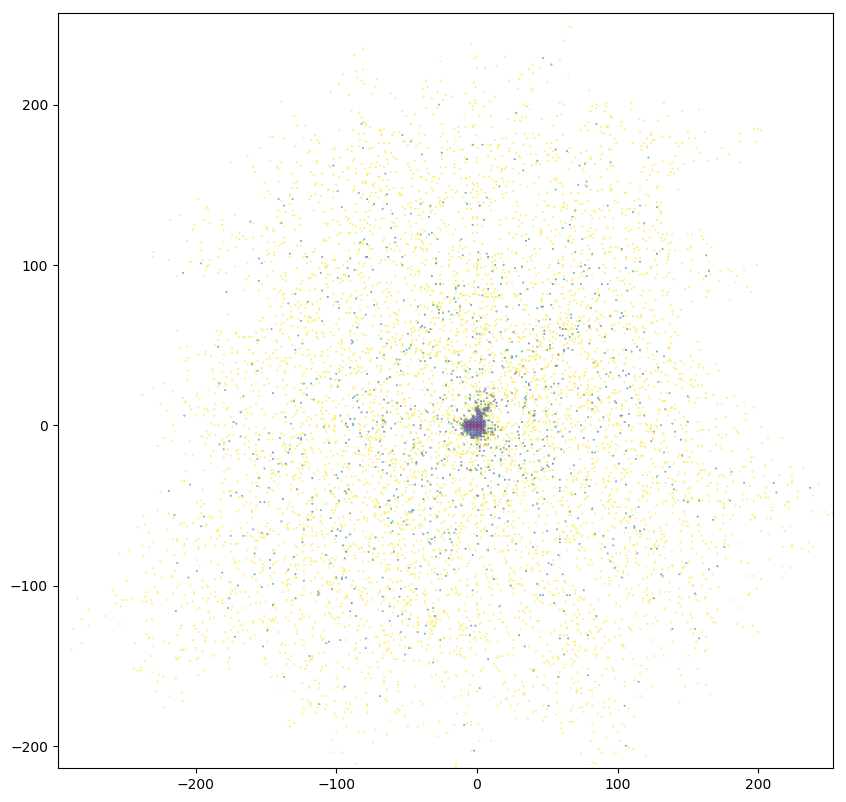

In [14]:
popindex.paint()

In [17]:
popindex[8000:8005]

[(160, 25), (-19, 59), (-138, 57), (-177, 11), (163, -107)]

[1.0632207835912633, 14.686430632352282]

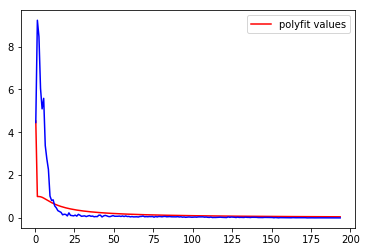

In [22]:
popindex[0:5000].curveFit(1)

[1.061818103220356, 16.93602683999137]

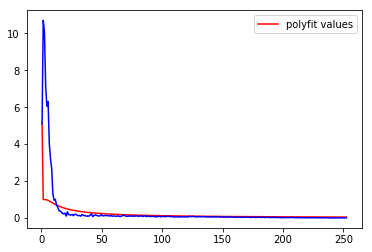

In [20]:
popindex.curveFit(1)

[0.8272574167070182, 3.680789917980368]

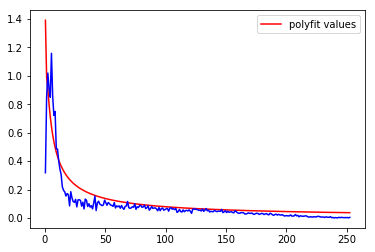

In [21]:
landindex = popindex.landCoor()
landindex.curveFit(1)

In [23]:
popindex.density()

1.3531799729364005

In [24]:
popindex[0:5000].density()

1.426126640045636

[[500,
  1000,
  1500,
  2000,
  2500,
  3000,
  3500,
  4000,
  4500,
  5000,
  5500,
  6000,
  6500,
  7000,
  7500,
  8000,
  8500,
  9000,
  9500],
 [2.6178010471204187,
  2.9585798816568047,
  2.092050209205021,
  1.7985611510791366,
  1.6545334215751157,
  1.5682174594877156,
  1.5105740181268883,
  1.4776505356483192,
  1.448342452526553,
  1.426126640045636,
  1.4095335725269094,
  1.3956734124214933,
  1.390076988879384,
  1.3836726625815379,
  1.3763993393283172,
  1.3712718546451834,
  1.3680991469499437,
  1.3657056145675266,
  1.3581129378127235]]

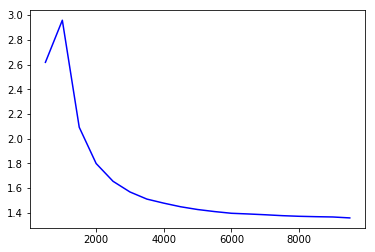

In [30]:
curveDensity(popindex,500)

In [28]:
for i in range(0,1):
    print(i)

0


## 15000

In [5]:
demo = city(4,0.2,15000,radius = 3)
popindex = demo.step()

1 3 2
2 3 3
4 3 4
5 3 5
5 3 6
5 3 7
5 3 8
9 3 9
9 3 10
9 3 11
9 3 12
9 3 13
9 3 14
9 3 15
9 3 16
9 3 17
9 3 18
12 3 19
12 3 20
12 3 21
12 3 22
12 3 23
12 3 24
12 3 25
12 3 26
12 3 27
12 3 28
12 3 29
12 3 30
12 3 31
12 3 32
12 3 33
12 3 34
12 3 35
12 3 36
12 3 37
12 3 38
12 3 39
12 3 40
12 3 41
12 3 42
12 3 43
12 3 44
12 3 45
12 3 46
12 3 47
12 3 48
12 3 49
12 3 50
12 3 51
12 3 52
12 3 53
12 3 54
12 3 55
12 3 56
12 3 57
12 3 58
12 3 59
12 3 60
12 3 61
12 3 62
12 3 63
12 3 64
12 3 65
12 3 66
12 3 67
12 3 68
12 3 69
12 3 70
12 3 71
12 3 72
12 3 73
12 3 74
12 3 75
12 3 76
12 3 77
12 3 78
13 3 79
13 3 80
13 3 81
13 3 82
13 3 83
13 3 84
13 3 85
13 3 86
13 3 87
13 3 88
13 3 89
13 3 90
13 3 91
13 3 92
13 3 93
13 3 94
13 3 95
13 3 96
13 3 97
13 3 98
13 3 99
13 3 100
13 3 101
13 3 102
13 3 103
13 3 104
13 3 105
13 3 106
13 3 107
13 3 108
13 3 109
13 3 110
13 3 111
13 3 112
13 3 113
13 3 114
13 3 115
13 3 116
13 3 117
13 3 118
13 3 119
13 3 120
13 3 121
13 3 122
13 3 123
13 3 124
13 3 125
13 3 12

22 3 988
22 3 989
22 3 990
22 3 991
22 3 992
22 3 993
22 3 994
22 3 995
22 3 996
22 3 997
22 3 998
22 3 999
22 3 1000
22 3 1001
22 3 1002
22 3 1003
22 3 1004
22 3 1005
22 3 1006
22 3 1007
22 3 1008
22 3 1009
22 3 1010
22 3 1011
22 3 1012
22 3 1013
22 3 1014
22 3 1015
22 3 1016
22 3 1017
22 3 1018
22 3 1019
22 3 1020
22 3 1021
22 3 1022
22 3 1023
22 3 1024
22 3 1025
22 3 1026
22 3 1027
22 3 1028
22 3 1029
22 3 1030
22 3 1031
22 3 1032
22 3 1033
22 3 1034
22 3 1035
22 3 1036
22 3 1037
22 3 1038
22 3 1039
22 3 1040
22 3 1041
22 3 1042
22 3 1043
22 3 1044
22 3 1045
22 3 1046
22 3 1047
22 3 1048
22 3 1049
22 3 1050
22 3 1051
22 3 1052
22 3 1053
22 3 1054
22 3 1055
22 3 1056
22 3 1057
22 3 1058
22 3 1059
22 3 1060
22 3 1061
22 3 1062
22 3 1063
22 3 1064
22 3 1065
22 3 1066
22 3 1067
22 3 1068
22 3 1069
22 3 1070
22 3 1071
22 3 1072
22 3 1073
22 3 1074
22 3 1075
22 3 1076
22 3 1077
22 3 1078
22 3 1079
22 3 1080
22 3 1081
22 3 1082
22 3 1083
22 3 1084
22 3 1085
22 3 1086
22 3 1087
22 3 1088
22

28 4 1820
28 4 1821
28 4 1822
28 4 1823
28 4 1824
28 4 1825
28 4 1826
28 4 1827
28 4 1828
28 4 1829
28 4 1830
28 4 1831
28 4 1832
28 4 1833
28 4 1834
28 4 1835
28 4 1836
28 4 1837
28 4 1838
28 4 1839
28 4 1840
28 4 1841
28 4 1842
28 4 1843
28 4 1844
28 4 1845
28 4 1846
28 4 1847
28 4 1848
28 4 1849
28 4 1850
28 4 1851
28 4 1852
28 4 1853
28 4 1854
28 4 1855
28 4 1856
28 4 1857
28 4 1858
28 4 1859
28 4 1860
28 4 1861
28 4 1862
28 4 1863
28 4 1864
28 4 1865
28 4 1866
28 4 1867
28 4 1868
29 5 1869
29 5 1870
29 5 1871
29 5 1872
29 5 1873
29 5 1874
29 5 1875
29 5 1876
29 5 1877
29 5 1878
29 5 1879
29 5 1880
29 5 1881
29 5 1882
29 5 1883
29 5 1884
29 5 1885
29 5 1886
29 5 1887
29 5 1888
29 5 1889
29 5 1890
29 5 1891
29 5 1892
29 5 1893
29 5 1894
29 5 1895
29 5 1896
29 5 1897
29 5 1898
29 5 1899
29 5 1900
29 5 1901
29 5 1902
29 5 1903
29 5 1904
29 5 1905
29 5 1906
29 5 1907
29 5 1908
29 5 1909
29 5 1910
29 5 1911
29 5 1912
29 5 1913
29 5 1914
29 5 1915
29 5 1916
29 5 1917
29 5 1918
29 5 1919


120 13 2653
120 13 2654
120 13 2655
120 13 2656
120 13 2657
120 13 2658
120 13 2659
120 13 2660
120 13 2661
120 13 2662
120 13 2663
120 13 2664
120 13 2665
120 13 2666
120 13 2667
120 13 2668
120 13 2669
120 13 2670
120 13 2671
120 13 2672
120 13 2673
120 13 2674
120 13 2675
120 13 2676
120 13 2677
120 13 2678
120 13 2679
120 13 2680
120 13 2681
120 13 2682
120 13 2683
120 13 2684
120 13 2685
120 13 2686
120 13 2687
120 13 2688
120 13 2689
120 13 2690
120 13 2691
120 13 2692
120 13 2693
120 13 2694
120 13 2695
120 13 2696
120 13 2697
120 13 2698
120 13 2699
120 13 2700
120 13 2701
120 13 2702
120 13 2703
120 13 2704
120 13 2705
120 13 2706
120 13 2707
120 13 2708
120 13 2709
120 13 2710
120 13 2711
120 13 2712
120 13 2713
120 13 2714
120 13 2715
120 13 2716
120 13 2717
120 13 2718
120 13 2719
120 13 2720
120 13 2721
120 13 2722
120 13 2723
120 13 2724
120 13 2725
120 13 2726
120 13 2727
120 13 2728
120 13 2729
120 13 2730
120 13 2731
120 13 2732
120 13 2733
120 13 2734
120 13 2735
120 

161 13 3485
161 13 3486
161 13 3487
161 13 3488
161 13 3489
161 13 3490
161 13 3491
161 13 3492
161 13 3493
161 13 3494
161 13 3495
161 13 3496
161 13 3497
161 13 3498
161 13 3499
161 13 3500
161 13 3501
161 13 3502
161 13 3503
161 13 3504
161 13 3505
161 13 3506
161 13 3507
161 13 3508
161 13 3509
161 13 3510
161 13 3511
161 13 3512
161 13 3513
161 13 3514
161 13 3515
161 13 3516
161 13 3517
161 13 3518
161 13 3519
161 13 3520
161 13 3521
161 13 3522
161 13 3523
161 13 3524
161 13 3525
161 13 3526
161 13 3527
161 13 3528
161 13 3529
161 13 3530
161 13 3531
161 13 3532
161 13 3533
161 13 3534
161 13 3535
161 13 3536
161 13 3537
161 13 3538
161 13 3539
161 13 3540
161 13 3541
161 13 3542
161 13 3543
161 13 3544
161 13 3545
161 13 3546
161 13 3547
161 13 3548
161 13 3549
161 13 3550
161 13 3551
161 13 3552
161 13 3553
161 13 3554
161 13 3555
161 13 3556
161 13 3557
161 13 3558
161 13 3559
161 13 3560
161 13 3561
161 13 3562
161 13 3563
161 13 3564
161 13 3565
161 13 3566
161 13 3567
161 

174 13 4318
174 13 4319
174 13 4320
174 13 4321
174 13 4322
174 13 4323
174 13 4324
174 13 4325
174 13 4326
174 13 4327
174 13 4328
174 13 4329
174 13 4330
174 13 4331
174 13 4332
174 13 4333
174 13 4334
174 13 4335
174 13 4336
174 13 4337
174 13 4338
174 13 4339
174 13 4340
174 13 4341
174 13 4342
174 13 4343
174 13 4344
174 13 4345
174 13 4346
174 13 4347
174 13 4348
180 13 4349
199 13 4350
199 13 4351
199 13 4352
199 13 4353
199 13 4354
199 13 4355
199 13 4356
199 13 4357
199 13 4358
199 13 4359
199 13 4360
199 13 4361
199 13 4362
199 13 4363
199 13 4364
199 13 4365
199 13 4366
199 13 4367
199 13 4368
199 13 4369
199 13 4370
199 13 4371
199 13 4372
199 13 4373
199 13 4374
199 13 4375
199 13 4376
199 13 4377
199 13 4378
199 13 4379
199 13 4380
199 13 4381
199 13 4382
199 13 4383
199 13 4384
199 13 4385
199 13 4386
199 13 4387
199 13 4388
199 13 4389
199 13 4390
199 13 4391
199 13 4392
199 13 4393
199 13 4394
199 13 4395
199 13 4396
199 13 4397
199 13 4398
199 13 4399
199 13 4400
199 

222 13 5150
222 13 5151
222 13 5152
222 13 5153
222 13 5154
222 13 5155
222 13 5156
222 13 5157
222 13 5158
222 13 5159
222 13 5160
222 13 5161
222 13 5162
222 13 5163
222 13 5164
222 13 5165
222 13 5166
222 13 5167
222 13 5168
222 13 5169
222 13 5170
222 13 5171
222 13 5172
222 13 5173
222 13 5174
222 13 5175
222 13 5176
222 13 5177
222 13 5178
222 13 5179
222 13 5180
222 13 5181
222 13 5182
222 13 5183
222 13 5184
222 13 5185
222 13 5186
222 13 5187
222 13 5188
222 13 5189
222 13 5190
222 13 5191
222 13 5192
222 13 5193
222 13 5194
222 13 5195
222 13 5196
222 13 5197
222 13 5198
222 13 5199
222 13 5200
222 13 5201
222 13 5202
222 13 5203
222 13 5204
222 13 5205
222 13 5206
222 13 5207
222 13 5208
222 13 5209
222 13 5210
222 13 5211
222 13 5212
222 13 5213
222 13 5214
222 13 5215
222 13 5216
222 13 5217
222 13 5218
222 13 5219
222 13 5220
222 13 5221
222 13 5222
222 13 5223
222 13 5224
222 13 5225
222 13 5226
222 13 5227
222 13 5228
222 13 5229
222 13 5230
222 13 5231
222 13 5232
222 

251 13 5983
251 13 5984
251 13 5985
251 13 5986
251 13 5987
251 13 5988
251 13 5989
251 13 5990
251 13 5991
251 13 5992
251 13 5993
251 13 5994
251 13 5995
251 13 5996
251 13 5997
251 13 5998
251 13 5999
251 13 6000
251 13 6001
251 13 6002
251 13 6003
251 13 6004
251 13 6005
251 13 6006
251 13 6007
251 13 6008
251 13 6009
251 13 6010
251 13 6011
251 13 6012
251 13 6013
251 13 6014
251 13 6015
251 13 6016
251 13 6017
251 13 6018
251 13 6019
251 13 6020
251 13 6021
251 13 6022
251 13 6023
251 13 6024
251 13 6025
251 13 6026
251 13 6027
251 13 6028
251 13 6029
251 13 6030
251 13 6031
251 13 6032
251 13 6033
251 13 6034
251 13 6035
251 13 6036
251 13 6037
251 13 6038
251 13 6039
251 13 6040
251 13 6041
251 13 6042
251 13 6043
251 13 6044
251 13 6045
251 13 6046
251 13 6047
251 13 6048
251 13 6049
251 13 6050
251 13 6051
251 13 6052
251 13 6053
251 13 6054
251 13 6055
251 13 6056
251 13 6057
251 13 6058
251 13 6059
251 13 6060
251 13 6061
251 13 6062
251 13 6063
251 13 6064
251 13 6065
251 

256 13 6815
256 13 6816
256 13 6817
256 13 6818
256 13 6819
256 13 6820
256 13 6821
256 13 6822
256 13 6823
256 13 6824
256 13 6825
256 13 6826
256 13 6827
256 13 6828
256 13 6829
256 13 6830
256 13 6831
256 13 6832
256 13 6833
256 13 6834
256 13 6835
256 13 6836
256 13 6837
256 13 6838
256 13 6839
256 13 6840
256 13 6841
256 13 6842
256 13 6843
256 13 6844
256 13 6845
256 13 6846
256 13 6847
256 13 6848
256 13 6849
256 13 6850
256 13 6851
256 13 6852
256 13 6853
256 13 6854
256 13 6855
256 13 6856
256 13 6857
256 13 6858
256 13 6859
256 13 6860
256 13 6861
256 13 6862
256 13 6863
256 13 6864
256 13 6865
256 13 6866
256 13 6867
256 13 6868
256 13 6869
256 13 6870
256 13 6871
256 13 6872
256 13 6873
256 13 6874
256 13 6875
256 13 6876
256 13 6877
256 13 6878
256 13 6879
256 13 6880
256 13 6881
256 13 6882
256 13 6883
256 13 6884
256 13 6885
256 13 6886
256 13 6887
256 13 6888
256 13 6889
256 13 6890
256 13 6891
256 13 6892
256 13 6893
256 13 6894
256 13 6895
256 13 6896
256 13 6897
256 

285 13 7648
285 13 7649
285 13 7650
285 13 7651
285 13 7652
285 13 7653
285 13 7654
285 13 7655
285 13 7656
285 13 7657
285 13 7658
285 13 7659
285 13 7660
285 13 7661
285 13 7662
285 13 7663
285 13 7664
285 13 7665
285 13 7666
285 13 7667
285 13 7668
285 13 7669
285 13 7670
285 13 7671
285 13 7672
285 13 7673
285 13 7674
285 13 7675
285 13 7676
285 13 7677
285 13 7678
285 13 7679
285 13 7680
285 13 7681
285 13 7682
285 13 7683
285 13 7684
285 13 7685
285 13 7686
285 13 7687
285 13 7688
285 13 7689
285 13 7690
285 13 7691
285 13 7692
285 13 7693
285 13 7694
285 13 7695
285 13 7696
285 13 7697
285 13 7698
285 13 7699
285 13 7700
285 13 7701
285 13 7702
285 13 7703
285 13 7704
285 13 7705
285 13 7706
285 13 7707
285 13 7708
285 13 7709
285 13 7710
285 13 7711
285 13 7712
285 13 7713
285 13 7714
285 13 7715
285 13 7716
285 13 7717
285 13 7718
285 13 7719
285 13 7720
285 13 7721
285 13 7722
285 13 7723
285 13 7724
285 13 7725
285 13 7726
285 13 7727
285 13 7728
285 13 7729
285 13 7730
285 

291 13 8480
291 13 8481
291 13 8482
291 13 8483
291 13 8484
291 13 8485
291 13 8486
291 13 8487
291 13 8488
291 13 8489
291 13 8490
291 13 8491
291 13 8492
291 13 8493
291 13 8494
291 13 8495
291 13 8496
291 13 8497
291 13 8498
291 13 8499
291 13 8500
291 13 8501
291 13 8502
291 13 8503
291 13 8504
291 13 8505
291 13 8506
291 13 8507
291 13 8508
291 13 8509
291 13 8510
291 13 8511
291 13 8512
291 13 8513
291 13 8514
291 13 8515
291 13 8516
291 13 8517
291 13 8518
291 13 8519
291 13 8520
291 13 8521
291 13 8522
291 13 8523
291 13 8524
291 13 8525
291 13 8526
291 13 8527
291 13 8528
291 13 8529
291 13 8530
291 13 8531
291 13 8532
291 13 8533
291 13 8534
291 13 8535
291 13 8536
291 13 8537
291 13 8538
291 13 8539
291 13 8540
291 13 8541
291 13 8542
291 13 8543
291 13 8544
291 13 8545
291 13 8546
291 13 8547
291 13 8548
291 13 8549
291 13 8550
291 13 8551
291 13 8552
291 13 8553
291 13 8554
291 13 8555
291 13 8556
291 13 8557
291 13 8558
291 13 8559
291 13 8560
291 13 8561
291 13 8562
291 

316 13 9313
316 13 9314
316 13 9315
316 13 9316
316 13 9317
316 13 9318
316 13 9319
316 13 9320
316 13 9321
316 13 9322
316 13 9323
316 13 9324
316 13 9325
316 13 9326
316 13 9327
316 13 9328
316 13 9329
316 13 9330
316 13 9331
316 13 9332
316 13 9333
316 13 9334
316 13 9335
316 13 9336
316 13 9337
316 13 9338
316 13 9339
316 13 9340
316 13 9341
316 13 9342
316 13 9343
316 13 9344
316 13 9345
316 13 9346
316 13 9347
316 13 9348
316 13 9349
316 13 9350
316 13 9351
316 13 9352
316 13 9353
316 13 9354
316 13 9355
316 13 9356
316 13 9357
316 13 9358
316 13 9359
316 13 9360
316 13 9361
316 13 9362
316 13 9363
316 13 9364
316 13 9365
316 13 9366
316 13 9367
316 13 9368
316 13 9369
316 13 9370
316 13 9371
316 13 9372
316 13 9373
316 13 9374
316 13 9375
316 13 9376
316 13 9377
316 13 9378
316 13 9379
316 13 9380
316 13 9381
316 13 9382
316 13 9383
316 13 9384
316 13 9385
316 13 9386
316 13 9387
316 13 9388
316 13 9389
316 13 9390
316 13 9391
316 13 9392
316 13 9393
316 13 9394
316 13 9395
316 

316 13 10145
316 13 10146
316 13 10147
316 13 10148
316 13 10149
316 13 10150
316 13 10151
316 13 10152
316 13 10153
316 13 10154
316 13 10155
316 13 10156
316 13 10157
316 13 10158
316 13 10159
316 13 10160
316 13 10161
316 13 10162
316 13 10163
316 13 10164
316 13 10165
316 13 10166
316 13 10167
316 13 10168
316 13 10169
316 13 10170
316 13 10171
316 13 10172
316 13 10173
316 13 10174
316 13 10175
316 13 10176
316 13 10177
316 13 10178
316 13 10179
316 13 10180
316 13 10181
316 13 10182
316 13 10183
316 13 10184
316 13 10185
316 13 10186
316 13 10187
316 13 10188
316 13 10189
316 13 10190
316 13 10191
316 13 10192
316 13 10193
316 13 10194
316 13 10195
316 13 10196
316 13 10197
316 13 10198
316 13 10199
316 13 10200
316 13 10201
316 13 10202
316 13 10203
316 13 10204
316 13 10205
316 13 10206
316 13 10207
316 13 10208
316 13 10209
316 13 10210
316 13 10211
316 13 10212
316 13 10213
316 13 10214
316 13 10215
316 13 10216
316 13 10217
316 13 10218
316 13 10219
316 13 10220
316 13 10221

324 13 10811
324 13 10812
324 13 10813
324 13 10814
324 13 10815
324 13 10816
324 13 10817
324 13 10818
324 13 10819
324 13 10820
324 13 10821
324 13 10822
324 13 10823
324 13 10824
324 13 10825
324 13 10826
324 13 10827
324 13 10828
324 13 10829
324 13 10830
324 13 10831
324 13 10832
324 13 10833
324 13 10834
324 13 10835
324 13 10836
324 13 10837
324 13 10838
324 13 10839
324 13 10840
324 13 10841
324 13 10842
324 13 10843
324 13 10844
324 13 10845
324 13 10846
324 13 10847
324 13 10848
324 13 10849
324 13 10850
324 13 10851
324 13 10852
324 13 10853
324 13 10854
324 13 10855
324 13 10856
324 13 10857
324 13 10858
324 13 10859
324 13 10860
324 13 10861
324 13 10862
324 13 10863
324 13 10864
324 13 10865
324 13 10866
324 13 10867
324 13 10868
324 13 10869
324 13 10870
324 13 10871
324 13 10872
324 13 10873
324 13 10874
324 13 10875
336 13 10876
336 13 10877
336 13 10878
336 13 10879
336 13 10880
336 13 10881
336 13 10882
336 13 10883
336 13 10884
336 13 10885
336 13 10886
336 13 10887

336 13 11477
336 13 11478
336 13 11479
336 13 11480
336 13 11481
336 13 11482
336 13 11483
336 13 11484
336 13 11485
336 13 11486
336 13 11487
336 13 11488
336 13 11489
336 13 11490
336 13 11491
336 13 11492
336 13 11493
336 13 11494
336 13 11495
336 13 11496
336 13 11497
336 13 11498
336 13 11499
336 13 11500
336 13 11501
336 13 11502
336 13 11503
336 13 11504
336 13 11505
336 13 11506
336 13 11507
336 13 11508
336 13 11509
336 13 11510
336 13 11511
336 13 11512
336 13 11513
336 13 11514
336 13 11515
336 13 11516
336 13 11517
336 13 11518
336 13 11519
336 13 11520
336 13 11521
336 13 11522
336 13 11523
336 13 11524
336 13 11525
336 13 11526
336 13 11527
336 13 11528
336 13 11529
336 13 11530
336 13 11531
336 13 11532
336 13 11533
336 13 11534
336 13 11535
336 13 11536
336 13 11537
336 13 11538
336 13 11539
336 13 11540
336 13 11541
336 13 11542
336 13 11543
336 13 11544
336 13 11545
336 13 11546
336 13 11547
336 13 11548
336 13 11549
336 13 11550
336 13 11551
336 13 11552
336 13 11553

336 13 12143
336 13 12144
336 13 12145
336 13 12146
336 13 12147
336 13 12148
336 13 12149
336 13 12150
336 13 12151
336 13 12152
336 13 12153
336 13 12154
336 13 12155
336 13 12156
336 13 12157
336 13 12158
336 13 12159
336 13 12160
336 13 12161
336 13 12162
336 13 12163
336 13 12164
336 13 12165
336 13 12166
336 13 12167
336 13 12168
336 13 12169
336 13 12170
336 13 12171
336 13 12172
336 13 12173
336 13 12174
336 13 12175
336 13 12176
336 13 12177
336 13 12178
336 13 12179
336 13 12180
336 13 12181
336 13 12182
336 13 12183
336 13 12184
336 13 12185
336 13 12186
336 13 12187
336 13 12188
336 13 12189
336 13 12190
336 13 12191
336 13 12192
336 13 12193
336 13 12194
336 13 12195
336 13 12196
336 13 12197
336 13 12198
336 13 12199
336 13 12200
336 13 12201
336 13 12202
336 13 12203
336 13 12204
336 13 12205
336 13 12206
336 13 12207
336 13 12208
336 13 12209
336 13 12210
336 13 12211
336 13 12212
336 13 12213
336 13 12214
336 13 12215
336 13 12216
336 13 12217
336 13 12218
336 13 12219

339 13 12809
339 13 12810
339 13 12811
339 13 12812
339 13 12813
339 13 12814
339 13 12815
339 13 12816
339 13 12817
340 13 12818
340 13 12819
340 13 12820
340 13 12821
340 13 12822
340 13 12823
340 13 12824
340 13 12825
340 13 12826
340 13 12827
340 13 12828
340 13 12829
340 13 12830
340 13 12831
340 13 12832
340 13 12833
340 13 12834
340 13 12835
340 13 12836
340 13 12837
340 13 12838
340 13 12839
340 13 12840
340 13 12841
340 13 12842
340 13 12843
340 13 12844
340 13 12845
340 13 12846
340 13 12847
340 13 12848
340 13 12849
340 13 12850
340 13 12851
340 13 12852
340 13 12853
340 13 12854
340 13 12855
340 13 12856
340 13 12857
340 13 12858
340 13 12859
340 13 12860
340 13 12861
340 13 12862
340 13 12863
340 13 12864
340 13 12865
340 13 12866
340 13 12867
340 13 12868
340 13 12869
340 13 12870
341 13 12871
341 13 12872
341 13 12873
341 13 12874
341 13 12875
341 13 12876
341 13 12877
341 13 12878
341 13 12879
341 13 12880
341 13 12881
341 13 12882
341 13 12883
341 13 12884
341 13 12885

348 13 13475
348 13 13476
348 13 13477
348 13 13478
348 13 13479
348 13 13480
348 13 13481
348 13 13482
348 13 13483
348 13 13484
348 13 13485
348 13 13486
348 13 13487
348 13 13488
348 13 13489
348 13 13490
348 13 13491
348 13 13492
348 13 13493
348 13 13494
348 13 13495
348 13 13496
348 13 13497
348 13 13498
348 13 13499
348 13 13500
348 13 13501
348 13 13502
348 13 13503
348 13 13504
348 13 13505
348 13 13506
348 13 13507
348 13 13508
348 13 13509
348 13 13510
348 13 13511
348 13 13512
348 13 13513
348 13 13514
348 13 13515
348 13 13516
348 13 13517
348 13 13518
348 13 13519
348 13 13520
348 13 13521
348 13 13522
348 13 13523
348 13 13524
348 13 13525
348 13 13526
348 13 13527
348 13 13528
348 13 13529
348 13 13530
348 13 13531
348 13 13532
348 13 13533
348 13 13534
348 13 13535
348 13 13536
348 13 13537
348 13 13538
348 13 13539
348 13 13540
348 13 13541
348 13 13542
348 13 13543
348 13 13544
348 13 13545
348 13 13546
348 13 13547
348 13 13548
348 13 13549
348 13 13550
348 13 13551

365 13 14141
365 13 14142
365 13 14143
365 13 14144
365 13 14145
365 13 14146
365 13 14147
365 13 14148
365 13 14149
365 13 14150
365 13 14151
365 13 14152
365 13 14153
365 13 14154
365 13 14155
365 13 14156
365 13 14157
365 13 14158
365 13 14159
365 13 14160
365 13 14161
365 13 14162
365 13 14163
365 13 14164
365 13 14165
365 13 14166
365 13 14167
365 13 14168
365 13 14169
365 13 14170
365 13 14171
365 13 14172
365 13 14173
365 13 14174
365 13 14175
365 13 14176
365 13 14177
365 13 14178
365 13 14179
365 13 14180
365 13 14181
365 13 14182
365 13 14183
365 13 14184
365 13 14185
365 13 14186
365 13 14187
365 13 14188
365 13 14189
365 13 14190
365 13 14191
365 13 14192
365 13 14193
365 13 14194
365 13 14195
365 13 14196
365 13 14197
365 13 14198
365 13 14199
365 13 14200
365 13 14201
365 13 14202
365 13 14203
365 13 14204
365 13 14205
365 13 14206
365 13 14207
365 13 14208
365 13 14209
365 13 14210
365 13 14211
365 13 14212
365 13 14213
365 13 14214
365 13 14215
365 13 14216
365 13 14217

370 13 14807
370 13 14808
370 13 14809
370 13 14810
370 13 14811
370 13 14812
370 13 14813
370 13 14814
370 13 14815
370 13 14816
370 13 14817
370 13 14818
370 13 14819
370 13 14820
370 13 14821
370 13 14822
370 13 14823
370 13 14824
370 13 14825
370 13 14826
370 13 14827
370 13 14828
370 13 14829
370 13 14830
370 13 14831
370 13 14832
370 13 14833
370 13 14834
370 13 14835
370 13 14836
370 13 14837
370 13 14838
370 13 14839
370 13 14840
370 13 14841
370 13 14842
370 13 14843
370 13 14844
370 13 14845
370 13 14846
370 13 14847
370 13 14848
370 13 14849
370 13 14850
370 13 14851
370 13 14852
370 13 14853
370 13 14854
370 13 14855
370 13 14856
370 13 14857
370 13 14858
370 13 14859
370 13 14860
370 13 14861
370 13 14862
370 13 14863
370 13 14864
370 13 14865
370 13 14866
370 13 14867
370 13 14868
370 13 14869
370 13 14870
370 13 14871
370 13 14872
370 13 14873
370 13 14874
370 13 14875
370 13 14876
370 13 14877
370 13 14878
370 13 14879
370 13 14880
370 13 14881
370 13 14882
370 13 14883

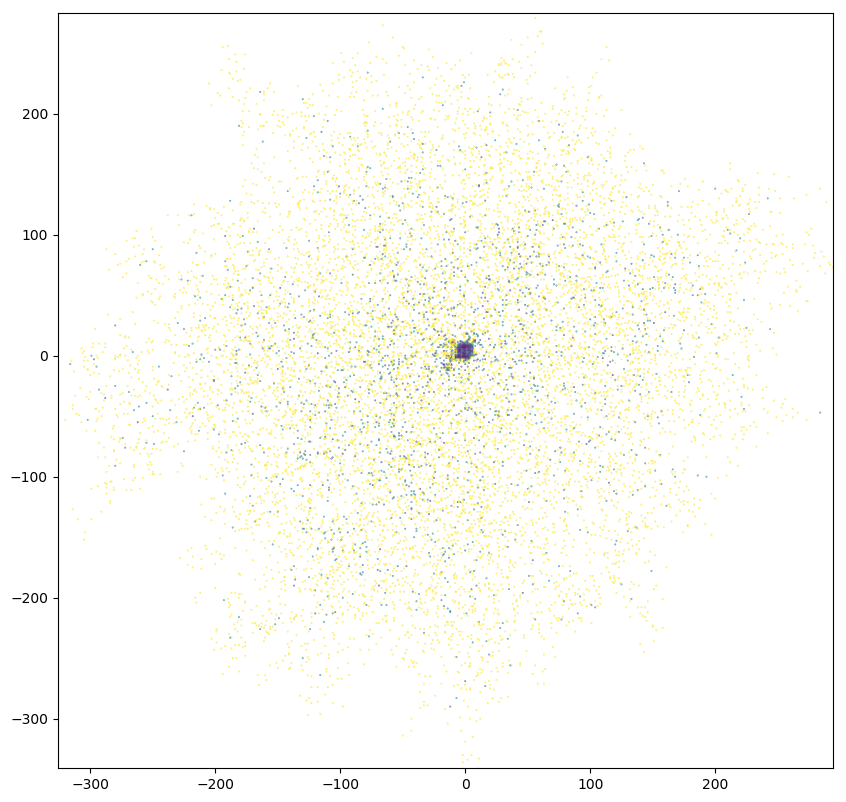

In [33]:
popindex.paint()

[1.0454715248914785, 17.049996148911152]

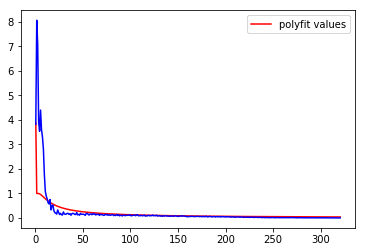

In [35]:
popindex.curveFit(1)

[0.7967334382541239, 3.318210830128378]

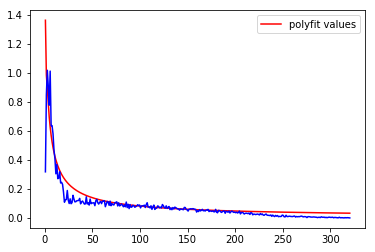

In [39]:
landindex = popindex.landCoor()
landindex.curveFit(1)

[[500,
  1000,
  1500,
  2000,
  2500,
  3000,
  3500,
  4000,
  4500,
  5000,
  5500,
  6000,
  6500,
  7000,
  7500,
  8000,
  8500,
  9000,
  9500,
  10000,
  10500,
  11000,
  11500,
  12000,
  12500,
  13000,
  13500,
  14000,
  14500],
 [2.6737967914438503,
  3.3003300330033003,
  3.7593984962406015,
  3.9447731755424065,
  3.4578146611341634,
  2.9013539651837523,
  2.5811209439528024,
  2.3446658851113718,
  2.1781219748305904,
  2.0798668885191347,
  1.995645863570392,
  1.9175455417066156,
  1.8523795953263038,
  1.805519731751354,
  1.7684508370667296,
  1.7368649587494571,
  1.7068273092369477,
  1.6819286114744907,
  1.6567840948726893,
  1.6412276382734285,
  1.6231256763023652,
  1.6084222839596432,
  1.5956708755376716,
  1.5866719555731852,
  1.5766902119071644,
  1.572897761645493,
  1.567398119122257,
  1.55902004454343,
  1.5532940546331013]]

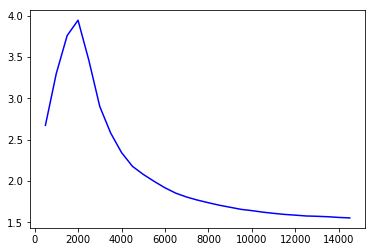

In [6]:
popindex.curveDensity(500)

## 自己定义一个popindex

输入让其生长

In [7]:
list = [1,2,3]

In [9]:
np.r_[[1,1],[1,1]]

array([1, 1, 1, 1])

In [10]:
np.array([1,2])

array([1, 2])

## h = 1000

In [41]:
demo = city(1000,0.2,5000,fx,r0 = 3)
popindex = demo.step()

1 3 2
2 3 3
3 3 4
3 3 5
3 3 6
3 3 7
3 3 8
3 3 9
4 3 10
6 3 11
6 3 12
6 3 13
6 3 14
6 3 15
6 3 16
6 3 17
6 3 18
6 3 19
6 3 20
6 3 21
6 3 22
6 3 23
6 3 24
6 3 25
6 3 26
6 3 27
6 3 28
7 3 29
7 3 30
7 3 31
7 3 32
7 3 33
8 3 34
8 3 35
8 3 36
8 3 37
8 3 38
8 3 39
8 3 40
8 3 41
8 3 42
10 3 43
10 3 44
10 3 45
10 3 46
10 3 47
10 3 48
10 3 49
10 3 50
10 3 51
10 3 52
10 3 53
10 3 54
10 3 55
10 3 56
10 3 57
10 3 58
10 3 59
10 3 60
10 3 61
10 3 62
10 3 63
10 3 64
12 3 65
12 3 66
12 3 67
12 3 68
12 3 69
12 3 70
12 3 71
12 3 72
12 3 73
12 3 74
12 3 75
12 3 76
12 3 77
12 3 78
12 3 79
12 3 80
12 3 81
12 3 82
12 3 83
12 3 84
12 3 85
12 3 86
12 3 87
12 3 88
12 3 89
12 3 90
12 3 91
12 3 92
12 3 93
12 3 94
12 3 95
12 3 96
12 3 97
12 3 98
12 3 99
12 3 100
12 3 101
12 3 102
12 3 103
12 3 104
12 3 105
12 3 106
12 3 107
12 3 108
12 3 109
12 3 110
12 3 111
12 3 112
12 3 113
12 3 114
12 3 115
12 3 116
12 3 117
12 3 118
12 3 119
12 3 120
12 3 121
12 3 122
12 3 123
12 3 124
12 3 125
12 3 126
12 3 127
12 3 128
12 3

33 12 1032
33 12 1033
33 12 1034
33 12 1035
36 12 1036
36 12 1037
36 12 1038
36 12 1039
36 12 1040
36 12 1041
36 12 1042
36 12 1043
36 12 1044
36 12 1045
36 12 1046
41 12 1047
41 12 1048
41 12 1049
41 12 1050
41 12 1051
41 12 1052
41 12 1053
43 12 1054
43 12 1055
47 12 1056
47 12 1057
47 12 1058
47 12 1059
47 12 1060
47 12 1061
47 12 1062
47 12 1063
47 12 1064
47 12 1065
47 12 1066
54 12 1067
54 12 1068
54 12 1069
54 12 1070
54 12 1071
54 12 1072
54 12 1073
54 12 1074
54 12 1075
54 12 1076
54 12 1077
54 12 1078
54 12 1079
54 12 1080
54 12 1081
54 12 1082
54 12 1083
54 12 1084
54 12 1085
54 12 1086
60 12 1087
60 12 1088
60 12 1089
60 12 1090
60 12 1091
60 12 1092
60 12 1093
60 12 1094
60 12 1095
60 12 1096
60 12 1097
60 12 1098
60 12 1099
60 12 1100
60 12 1101
60 12 1102
60 12 1103
60 12 1104
60 12 1105
66 12 1106
66 12 1107
66 12 1108
66 12 1109
66 12 1110
66 12 1111
66 12 1112
66 12 1113
66 12 1114
66 12 1115
66 12 1116
66 12 1117
66 12 1118
66 12 1119
66 12 1120
67 13 1121
67 13 1122

175 13 1865
175 13 1866
175 13 1867
175 13 1868
175 13 1869
175 13 1870
175 13 1871
175 13 1872
175 13 1873
175 13 1874
175 13 1875
175 13 1876
175 13 1877
175 13 1878
175 13 1879
175 13 1880
175 13 1881
175 13 1882
175 13 1883
175 13 1884
175 13 1885
175 13 1886
175 13 1887
175 13 1888
175 13 1889
175 13 1890
175 13 1891
175 13 1892
175 13 1893
175 13 1894
175 13 1895
175 13 1896
175 13 1897
175 13 1898
175 13 1899
175 13 1900
175 13 1901
175 13 1902
175 13 1903
175 13 1904
175 13 1905
175 13 1906
175 13 1907
175 13 1908
175 13 1909
175 13 1910
175 13 1911
175 13 1912
175 13 1913
175 13 1914
175 13 1915
175 13 1916
175 13 1917
175 13 1918
175 13 1919
175 13 1920
175 13 1921
175 13 1922
175 13 1923
175 13 1924
175 13 1925
175 13 1926
175 13 1927
175 13 1928
175 13 1929
175 13 1930
175 13 1931
175 13 1932
175 13 1933
175 13 1934
175 13 1935
175 13 1936
177 13 1937
177 13 1938
177 13 1939
177 13 1940
177 13 1941
177 13 1942
177 13 1943
177 13 1944
177 13 1945
177 13 1946
177 13 1947
177 

236 13 2697
236 13 2698
236 13 2699
236 13 2700
236 13 2701
236 13 2702
236 13 2703
236 13 2704
236 13 2705
236 13 2706
236 13 2707
236 13 2708
236 13 2709
236 13 2710
236 13 2711
236 13 2712
236 13 2713
236 13 2714
236 13 2715
236 13 2716
236 13 2717
236 13 2718
236 13 2719
236 13 2720
236 13 2721
236 13 2722
236 13 2723
236 13 2724
236 13 2725
236 13 2726
236 13 2727
236 13 2728
236 13 2729
236 13 2730
236 13 2731
236 13 2732
236 13 2733
236 13 2734
236 13 2735
236 13 2736
236 13 2737
236 13 2738
236 13 2739
236 13 2740
236 13 2741
236 13 2742
236 13 2743
236 13 2744
236 13 2745
236 13 2746
236 13 2747
236 13 2748
236 13 2749
236 13 2750
236 13 2751
236 13 2752
236 13 2753
236 13 2754
236 13 2755
236 13 2756
236 13 2757
236 13 2758
236 13 2759
236 13 2760
236 13 2761
236 13 2762
236 13 2763
236 13 2764
236 13 2765
236 13 2766
236 13 2767
236 13 2768
236 13 2769
258 13 2770
258 13 2771
258 13 2772
258 13 2773
258 13 2774
258 13 2775
258 13 2776
258 13 2777
258 13 2778
258 13 2779
258 

266 13 3530
266 13 3531
266 13 3532
266 13 3533
266 13 3534
266 13 3535
266 13 3536
266 13 3537
266 13 3538
266 13 3539
266 13 3540
266 13 3541
266 13 3542
266 13 3543
266 13 3544
266 13 3545
266 13 3546
266 13 3547
266 13 3548
266 13 3549
266 13 3550
266 13 3551
266 13 3552
266 13 3553
266 13 3554
266 13 3555
266 13 3556
266 13 3557
266 13 3558
266 13 3559
266 13 3560
266 13 3561
266 13 3562
266 13 3563
266 13 3564
266 13 3565
266 13 3566
266 13 3567
266 13 3568
266 13 3569
266 13 3570
266 13 3571
266 13 3572
266 13 3573
266 13 3574
266 13 3575
266 13 3576
266 13 3577
266 13 3578
266 13 3579
266 13 3580
266 13 3581
266 13 3582
266 13 3583
266 13 3584
266 13 3585
266 13 3586
266 13 3587
266 13 3588
272 13 3589
272 13 3590
272 13 3591
272 13 3592
272 13 3593
272 13 3594
272 13 3595
272 13 3596
272 13 3597
272 13 3598
272 13 3599
272 13 3600
272 13 3601
272 13 3602
272 13 3603
272 13 3604
272 13 3605
272 13 3606
272 13 3607
272 13 3608
272 13 3609
272 13 3610
272 13 3611
272 13 3612
272 

282 13 4362
282 13 4363
282 13 4364
282 13 4365
282 13 4366
282 13 4367
282 13 4368
282 13 4369
282 13 4370
282 13 4371
282 13 4372
282 13 4373
282 13 4374
282 13 4375
282 13 4376
282 13 4377
282 13 4378
282 13 4379
282 13 4380
282 13 4381
282 13 4382
282 13 4383
282 13 4384
282 13 4385
282 13 4386
282 13 4387
282 13 4388
282 13 4389
282 13 4390
282 13 4391
282 13 4392
282 13 4393
282 13 4394
282 13 4395
282 13 4396
282 13 4397
282 13 4398
282 13 4399
282 13 4400
282 13 4401
282 13 4402
282 13 4403
282 13 4404
282 13 4405
282 13 4406
282 13 4407
282 13 4408
282 13 4409
282 13 4410
282 13 4411
282 13 4412
282 13 4413
282 13 4414
282 13 4415
282 13 4416
282 13 4417
282 13 4418
282 13 4419
282 13 4420
282 13 4421
282 13 4422
282 13 4423
282 13 4424
282 13 4425
282 13 4426
282 13 4427
282 13 4428
282 13 4429
282 13 4430
282 13 4431
282 13 4432
282 13 4433
282 13 4434
282 13 4435
282 13 4436
282 13 4437
282 13 4438
282 13 4439
282 13 4440
282 13 4441
282 13 4442
282 13 4443
282 13 4444
282 

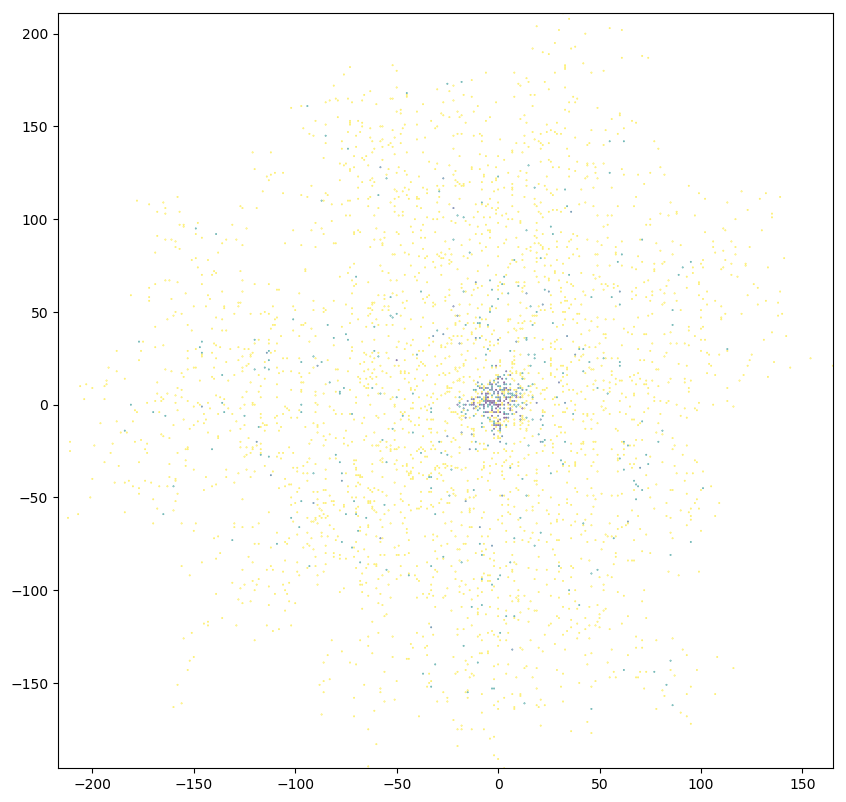

In [42]:
popindex.paint()

In [43]:
popindex.sideView()

Counter({29: 1,
         105: 1,
         20: 2,
         39: 1,
         28: 1,
         2: 326,
         3: 74,
         11: 3,
         75: 1,
         59: 1,
         31: 1,
         106: 1,
         47: 1,
         17: 1,
         14: 2,
         1: 2829,
         13: 3,
         4: 24,
         5: 16,
         46: 1,
         15: 1,
         45: 1,
         23: 1,
         10: 2,
         8: 7,
         7: 7,
         12: 3,
         6: 10,
         25: 1,
         16: 1,
         9: 3,
         27: 1})

In [44]:
demo2 = city(1000,0.2,10000,fx,r0 = 3,gloomyindex = popindex)
popindex2 = demo2.step2()

232 13 5001
232 13 5002
232 13 5003
232 13 5004
232 13 5005
232 13 5006
232 13 5007
232 13 5008
232 13 5009
266 13 5010
266 13 5011
266 13 5012
266 13 5013
266 13 5014
266 13 5015
266 13 5016
266 13 5017
266 13 5018
266 13 5019
266 13 5020
266 13 5021
266 13 5022
281 13 5023
281 13 5024
281 13 5025
281 13 5026
281 13 5027
281 13 5028
281 13 5029
281 13 5030
281 13 5031
281 13 5032
281 13 5033
281 13 5034
281 13 5035
281 13 5036
281 13 5037
281 13 5038
281 13 5039
281 13 5040
281 13 5041
281 13 5042
281 13 5043
281 13 5044
281 13 5045
281 13 5046
281 13 5047
281 13 5048
281 13 5049
281 13 5050
281 13 5051
281 13 5052
281 13 5053
281 13 5054
281 13 5055
281 13 5056
281 13 5057
281 13 5058
281 13 5059
281 13 5060
281 13 5061
281 13 5062
281 13 5063
281 13 5064
281 13 5065
281 13 5066
281 13 5067
281 13 5068
281 13 5069
281 13 5070
281 13 5071
281 13 5072
281 13 5073
281 13 5074
281 13 5075
281 13 5076
281 13 5077
281 13 5078
281 13 5079
281 13 5080
281 13 5081
281 13 5082
281 13 5083
281 

295 13 5687
295 13 5688
295 13 5689
295 13 5690
295 13 5691
295 13 5692
295 13 5693
295 13 5694
295 13 5695
295 13 5696
295 13 5697
295 13 5698
295 13 5699
295 13 5700
295 13 5701
295 13 5702
295 13 5703
295 13 5704
295 13 5705
295 13 5706
295 13 5707
295 13 5708
295 13 5709
295 13 5710
295 13 5711
295 13 5712
305 13 5713
305 13 5714
305 13 5715
305 13 5716
305 13 5717
305 13 5718
305 13 5719
305 13 5720
305 13 5721
305 13 5722
305 13 5723
305 13 5724
305 13 5725
305 13 5726
305 13 5727
305 13 5728
305 13 5729
305 13 5730
305 13 5731
305 13 5732
305 13 5733
305 13 5734
305 13 5735
307 13 5736
310 13 5737
310 13 5738
310 13 5739
310 13 5740
310 13 5741
310 13 5742
310 13 5743
310 13 5744
310 13 5745
310 13 5746
310 13 5747
310 13 5748
310 13 5749
310 13 5750
310 13 5751
310 13 5752
310 13 5753
310 13 5754
310 13 5755
310 13 5756
310 13 5757
310 13 5758
310 13 5759
310 13 5760
310 13 5761
310 13 5762
310 13 5763
310 13 5764
310 13 5765
310 13 5766
310 13 5767
310 13 5768
310 13 5769
310 

338 13 6520
338 13 6521
338 13 6522
338 13 6523
338 13 6524
338 13 6525
338 13 6526
338 13 6527
338 13 6528
338 13 6529
338 13 6530
338 13 6531
338 13 6532
338 13 6533
338 13 6534
338 13 6535
338 13 6536
338 13 6537
338 13 6538
338 13 6539
338 13 6540
338 13 6541
338 13 6542
338 13 6543
338 13 6544
338 13 6545
338 13 6546
338 13 6547
338 13 6548
338 13 6549
338 13 6550
338 13 6551
338 13 6552
338 13 6553
338 13 6554
338 13 6555
338 13 6556
338 13 6557
338 13 6558
338 13 6559
338 13 6560
338 13 6561
338 13 6562
338 13 6563
338 13 6564
338 13 6565
338 13 6566
338 13 6567
338 13 6568
338 13 6569
338 13 6570
338 13 6571
338 13 6572
338 13 6573
338 13 6574
338 13 6575
338 13 6576
338 13 6577
338 13 6578
338 13 6579
338 13 6580
338 13 6581
338 13 6582
338 13 6583
338 13 6584
338 13 6585
338 13 6586
338 13 6587
338 13 6588
338 13 6589
338 13 6590
338 13 6591
338 13 6592
338 13 6593
338 13 6594
338 13 6595
338 13 6596
338 13 6597
338 13 6598
338 13 6599
338 13 6600
338 13 6601
338 13 6602
338 

348 13 7352
348 13 7353
348 13 7354
348 13 7355
348 13 7356
348 13 7357
348 13 7358
348 13 7359
348 13 7360
348 13 7361
348 13 7362
348 13 7363
348 13 7364
348 13 7365
348 13 7366
348 13 7367
348 13 7368
348 13 7369
348 13 7370
348 13 7371
348 13 7372
348 13 7373
348 13 7374
348 13 7375
348 13 7376
348 13 7377
348 13 7378
348 13 7379
348 13 7380
348 13 7381
348 13 7382
348 13 7383
348 13 7384
348 13 7385
348 13 7386
348 13 7387
348 13 7388
348 13 7389
348 13 7390
348 13 7391
348 13 7392
348 13 7393
348 13 7394
348 13 7395
348 13 7396
348 13 7397
348 13 7398
348 13 7399
348 13 7400
348 13 7401
348 13 7402
348 13 7403
348 13 7404
348 13 7405
348 13 7406
348 13 7407
348 13 7408
348 13 7409
348 13 7410
348 13 7411
348 13 7412
348 13 7413
348 13 7414
348 13 7415
348 13 7416
348 13 7417
348 13 7418
348 13 7419
348 13 7420
348 13 7421
348 13 7422
348 13 7423
348 13 7424
348 13 7425
348 13 7426
348 13 7427
348 13 7428
348 13 7429
348 13 7430
348 13 7431
348 13 7432
348 13 7433
348 13 7434
348 

390 13 8170
390 13 8171
390 13 8172
390 13 8173
390 13 8174
390 13 8175
390 13 8176
390 13 8177
390 13 8178
390 13 8179
390 13 8180
390 13 8181
390 13 8182
390 13 8183
390 13 8184
390 13 8185
390 13 8186
390 13 8187
390 13 8188
390 13 8189
390 13 8190
390 13 8191
390 13 8192
390 13 8193
390 13 8194
390 13 8195
390 13 8196
390 13 8197
390 13 8198
390 13 8199
390 13 8200
390 13 8201
390 13 8202
390 13 8203
390 13 8204
390 13 8205
390 13 8206
390 13 8207
390 13 8208
390 13 8209
390 13 8210
390 13 8211
390 13 8212
390 13 8213
390 13 8214
390 13 8215
390 13 8216
390 13 8217
390 13 8218
390 13 8219
390 13 8220
390 13 8221
390 13 8222
390 13 8223
390 13 8224
390 13 8225
390 13 8226
390 13 8227
390 13 8228
390 13 8229
390 13 8230
390 13 8231
390 13 8232
390 13 8233
390 13 8234
390 13 8235
390 13 8236
390 13 8237
390 13 8238
390 13 8239
390 13 8240
390 13 8241
390 13 8242
390 13 8243
390 13 8244
390 13 8245
390 13 8246
390 13 8247
390 13 8248
390 13 8249
390 13 8250
390 13 8251
390 13 8252
390 

406 13 9017
406 13 9018
406 13 9019
406 13 9020
406 13 9021
406 13 9022
406 13 9023
406 13 9024
406 13 9025
406 13 9026
406 13 9027
406 13 9028
406 13 9029
406 13 9030
406 13 9031
406 13 9032
406 13 9033
406 13 9034
406 13 9035
406 13 9036
406 13 9037
406 13 9038
406 13 9039
406 13 9040
406 13 9041
406 13 9042
406 13 9043
406 13 9044
406 13 9045
406 13 9046
406 13 9047
406 13 9048
406 13 9049
406 13 9050
406 13 9051
406 13 9052
406 13 9053
406 13 9054
406 13 9055
406 13 9056
406 13 9057
406 13 9058
406 13 9059
406 13 9060
406 13 9061
406 13 9062
406 13 9063
406 13 9064
406 13 9065
406 13 9066
406 13 9067
406 13 9068
406 13 9069
406 13 9070
406 13 9071
406 13 9072
406 13 9073
406 13 9074
406 13 9075
406 13 9076
406 13 9077
406 13 9078
406 13 9079
406 13 9080
406 13 9081
406 13 9082
406 13 9083
406 13 9084
406 13 9085
406 13 9086
406 13 9087
406 13 9088
406 13 9089
406 13 9090
406 13 9091
406 13 9092
406 13 9093
406 13 9094
406 13 9095
406 13 9096
406 13 9097
406 13 9098
406 13 9099
406 

412 13 9849
412 13 9850
412 13 9851
412 13 9852
412 13 9853
412 13 9854
412 13 9855
412 13 9856
412 13 9857
412 13 9858
412 13 9859
412 13 9860
412 13 9861
412 13 9862
412 13 9863
412 13 9864
412 13 9865
412 13 9866
412 13 9867
412 13 9868
412 13 9869
412 13 9870
412 13 9871
412 13 9872
412 13 9873
412 13 9874
412 13 9875
412 13 9876
412 13 9877
412 13 9878
412 13 9879
412 13 9880
412 13 9881
412 13 9882
412 13 9883
412 13 9884
412 13 9885
412 13 9886
412 13 9887
412 13 9888
412 13 9889
412 13 9890
412 13 9891
412 13 9892
412 13 9893
412 13 9894
412 13 9895
412 13 9896
412 13 9897
412 13 9898
412 13 9899
412 13 9900
412 13 9901
412 13 9902
412 13 9903
412 13 9904
412 13 9905
412 13 9906
412 13 9907
412 13 9908
412 13 9909
412 13 9910
412 13 9911
412 13 9912
412 13 9913
412 13 9914
412 13 9915
412 13 9916
412 13 9917
412 13 9918
412 13 9919
412 13 9920
412 13 9921
412 13 9922
412 13 9923
412 13 9924
412 13 9925
412 13 9926
412 13 9927
412 13 9928
412 13 9929
412 13 9930
412 13 9931
412 

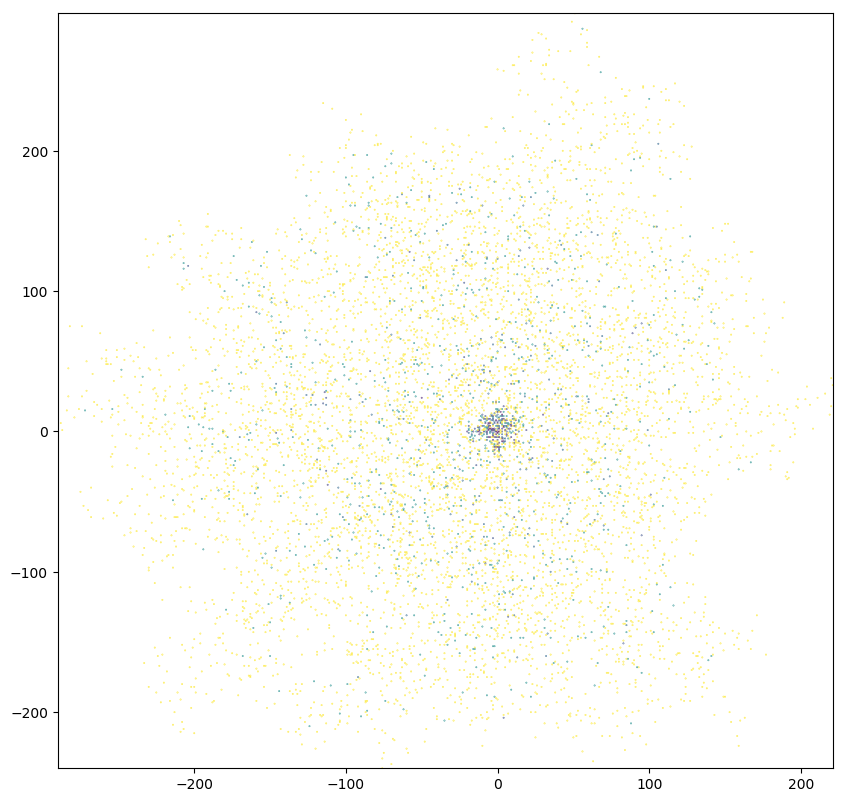

In [45]:
popindex2.paint()

[0.6885468008443728, 1.6030145232733426]

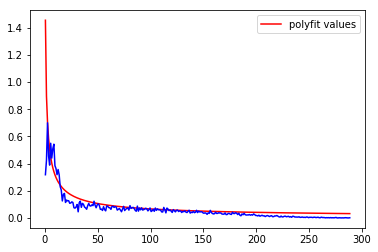

In [46]:
landindex = popindex.landCoor()
landindex.curveFit(1)

[0.6885468008443728, 1.6030145232733426]

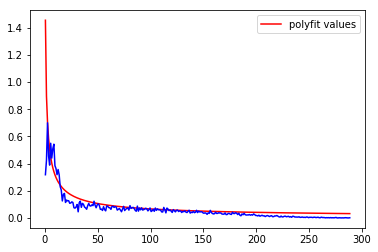

In [47]:
landindex2 = popindex2.landCoor()
landindex2.curveFit(1)

In [49]:
demo = city(1000,0.2,10000,fx,r0 = 3)
popindex = demo.step()

1 3 2
2 3 3
2 3 4
2 3 5
2 3 6
4 3 7
4 3 8
4 3 9
4 3 10
4 3 11
4 3 12
5 3 13
5 3 14
5 3 15
5 3 16
5 3 17
5 3 18
5 3 19
7 3 20
7 3 21
7 3 22
7 3 23
7 3 24
7 3 25
7 3 26
7 3 27
7 3 28
7 3 29
7 3 30
7 3 31
7 3 32
7 3 33
7 3 34
7 3 35
7 3 36
7 3 37
7 3 38
7 3 39
7 3 40
7 3 41
7 3 42
7 3 43
7 3 44
7 3 45
7 3 46
7 3 47
7 3 48
7 3 49
7 3 50
7 3 51
7 3 52
8 3 53
8 3 54
8 3 55
8 3 56
8 3 57
8 3 58
8 3 59
8 3 60
8 3 61
8 3 62
8 3 63
8 3 64
8 3 65
8 3 66
8 3 67
8 3 68
9 3 69
9 3 70
9 3 71
9 3 72
9 3 73
9 3 74
9 3 75
9 3 76
9 3 77
9 3 78
9 3 79
9 3 80
9 3 81
9 3 82
9 3 83
9 3 84
9 3 85
9 3 86
9 3 87
9 3 88
9 3 89
10 3 90
10 3 91
10 3 92
10 3 93
10 3 94
10 3 95
10 3 96
10 3 97
10 3 98
10 3 99
10 3 100
10 3 101
10 3 102
10 3 103
10 3 104
13 3 105
13 3 106
13 3 107
13 3 108
13 3 109
13 3 110
13 3 111
13 3 112
13 3 113
16 3 114
16 3 115
16 3 116
16 3 117
16 3 118
16 3 119
16 3 120
16 3 121
16 3 122
16 3 123
16 3 124
16 3 125
16 3 126
16 3 127
16 3 128
16 3 129
16 3 130
16 3 131
16 3 132
16 3 133
16 3 1

100 13 994
100 13 995
100 13 996
100 13 997
100 13 998
100 13 999
100 13 1000
100 13 1001
100 13 1002
100 13 1003
100 13 1004
100 13 1005
100 13 1006
100 13 1007
100 13 1008
122 13 1009
122 13 1010
122 13 1011
122 13 1012
122 13 1013
122 13 1014
122 13 1015
122 13 1016
122 13 1017
122 13 1018
122 13 1019
122 13 1020
122 13 1021
122 13 1022
122 13 1023
122 13 1024
122 13 1025
122 13 1026
122 13 1027
122 13 1028
122 13 1029
122 13 1030
122 13 1031
122 13 1032
122 13 1033
122 13 1034
122 13 1035
122 13 1036
122 13 1037
122 13 1038
122 13 1039
122 13 1040
122 13 1041
122 13 1042
122 13 1043
122 13 1044
122 13 1045
122 13 1046
122 13 1047
122 13 1048
122 13 1049
122 13 1050
122 13 1051
122 13 1052
122 13 1053
122 13 1054
122 13 1055
122 13 1056
122 13 1057
122 13 1058
122 13 1059
122 13 1060
122 13 1061
122 13 1062
122 13 1063
122 13 1064
122 13 1065
122 13 1066
122 13 1067
122 13 1068
122 13 1069
122 13 1070
122 13 1071
122 13 1072
122 13 1073
122 13 1074
122 13 1075
122 13 1076
122 13 107

176 13 1826
176 13 1827
176 13 1828
176 13 1829
176 13 1830
176 13 1831
176 13 1832
176 13 1833
176 13 1834
176 13 1835
176 13 1836
176 13 1837
176 13 1838
176 13 1839
176 13 1840
176 13 1841
176 13 1842
176 13 1843
176 13 1844
176 13 1845
176 13 1846
176 13 1847
176 13 1848
176 13 1849
176 13 1850
176 13 1851
176 13 1852
176 13 1853
176 13 1854
176 13 1855
176 13 1856
176 13 1857
176 13 1858
176 13 1859
176 13 1860
176 13 1861
176 13 1862
176 13 1863
176 13 1864
176 13 1865
176 13 1866
176 13 1867
176 13 1868
176 13 1869
176 13 1870
176 13 1871
176 13 1872
176 13 1873
176 13 1874
176 13 1875
176 13 1876
176 13 1877
176 13 1878
176 13 1879
176 13 1880
176 13 1881
176 13 1882
176 13 1883
176 13 1884
176 13 1885
176 13 1886
176 13 1887
176 13 1888
176 13 1889
176 13 1890
176 13 1891
176 13 1892
176 13 1893
176 13 1894
176 13 1895
176 13 1896
176 13 1897
176 13 1898
176 13 1899
176 13 1900
176 13 1901
176 13 1902
176 13 1903
176 13 1904
176 13 1905
176 13 1906
176 13 1907
176 13 1908
176 

203 13 2659
203 13 2660
203 13 2661
203 13 2662
203 13 2663
203 13 2664
203 13 2665
203 13 2666
203 13 2667
203 13 2668
203 13 2669
203 13 2670
203 13 2671
203 13 2672
203 13 2673
203 13 2674
203 13 2675
203 13 2676
203 13 2677
203 13 2678
203 13 2679
203 13 2680
203 13 2681
203 13 2682
203 13 2683
203 13 2684
203 13 2685
203 13 2686
203 13 2687
203 13 2688
203 13 2689
203 13 2690
203 13 2691
203 13 2692
203 13 2693
203 13 2694
203 13 2695
203 13 2696
203 13 2697
203 13 2698
203 13 2699
203 13 2700
203 13 2701
203 13 2702
203 13 2703
203 13 2704
203 13 2705
203 13 2706
203 13 2707
203 13 2708
203 13 2709
203 13 2710
203 13 2711
203 13 2712
203 13 2713
203 13 2714
203 13 2715
203 13 2716
203 13 2717
203 13 2718
203 13 2719
203 13 2720
203 13 2721
203 13 2722
203 13 2723
217 13 2724
217 13 2725
217 13 2726
217 13 2727
217 13 2728
217 13 2729
217 13 2730
217 13 2731
217 13 2732
217 13 2733
217 13 2734
217 13 2735
217 13 2736
217 13 2737
217 13 2738
217 13 2739
217 13 2740
217 13 2741
217 

232 13 3491
232 13 3492
232 13 3493
232 13 3494
245 13 3495
245 13 3496
245 13 3497
245 13 3498
245 13 3499
245 13 3500
245 13 3501
245 13 3502
245 13 3503
245 13 3504
245 13 3505
245 13 3506
245 13 3507
245 13 3508
245 13 3509
245 13 3510
245 13 3511
245 13 3512
245 13 3513
245 13 3514
245 13 3515
245 13 3516
245 13 3517
245 13 3518
245 13 3519
245 13 3520
245 13 3521
245 13 3522
245 13 3523
245 13 3524
245 13 3525
245 13 3526
245 13 3527
245 13 3528
245 13 3529
245 13 3530
245 13 3531
245 13 3532
245 13 3533
245 13 3534
245 13 3535
245 13 3536
245 13 3537
245 13 3538
245 13 3539
245 13 3540
245 13 3541
245 13 3542
245 13 3543
245 13 3544
245 13 3545
245 13 3546
245 13 3547
245 13 3548
245 13 3549
245 13 3550
245 13 3551
245 13 3552
245 13 3553
245 13 3554
245 13 3555
245 13 3556
245 13 3557
245 13 3558
245 13 3559
245 13 3560
245 13 3561
245 13 3562
245 13 3563
245 13 3564
245 13 3565
245 13 3566
245 13 3567
245 13 3568
245 13 3569
245 13 3570
245 13 3571
245 13 3572
245 13 3573
245 

266 13 4324
266 13 4325
266 13 4326
266 13 4327
266 13 4328
266 13 4329
266 13 4330
266 13 4331
266 13 4332
266 13 4333
266 13 4334
266 13 4335
266 13 4336
266 13 4337
266 13 4338
266 13 4339
266 13 4340
266 13 4341
266 13 4342
266 13 4343
266 13 4344
266 13 4345
266 13 4346
266 13 4347
266 13 4348
266 13 4349
266 13 4350
266 13 4351
266 13 4352
266 13 4353
266 13 4354
266 13 4355
266 13 4356
266 13 4357
266 13 4358
266 13 4359
266 13 4360
266 13 4361
266 13 4362
266 13 4363
266 13 4364
266 13 4365
266 13 4366
266 13 4367
266 13 4368
266 13 4369
266 13 4370
266 13 4371
266 13 4372
266 13 4373
266 13 4374
266 13 4375
266 13 4376
266 13 4377
266 13 4378
266 13 4379
266 13 4380
266 13 4381
266 13 4382
266 13 4383
266 13 4384
266 13 4385
266 13 4386
266 13 4387
266 13 4388
266 13 4389
266 13 4390
266 13 4391
266 13 4392
266 13 4393
266 13 4394
266 13 4395
266 13 4396
266 13 4397
266 13 4398
266 13 4399
266 13 4400
266 13 4401
266 13 4402
266 13 4403
266 13 4404
266 13 4405
266 13 4406
266 

287 13 5156
287 13 5157
287 13 5158
287 13 5159
287 13 5160
287 13 5161
287 13 5162
287 13 5163
287 13 5164
287 13 5165
287 13 5166
287 13 5167
287 13 5168
287 13 5169
287 13 5170
287 13 5171
287 13 5172
287 13 5173
287 13 5174
287 13 5175
287 13 5176
287 13 5177
287 13 5178
287 13 5179
287 13 5180
287 13 5181
287 13 5182
287 13 5183
287 13 5184
287 13 5185
287 13 5186
287 13 5187
287 13 5188
287 13 5189
287 13 5190
287 13 5191
287 13 5192
287 13 5193
287 13 5194
287 13 5195
287 13 5196
287 13 5197
287 13 5198
287 13 5199
287 13 5200
287 13 5201
287 13 5202
287 13 5203
287 13 5204
287 13 5205
287 13 5206
287 13 5207
287 13 5208
287 13 5209
287 13 5210
287 13 5211
287 13 5212
287 13 5213
287 13 5214
287 13 5215
287 13 5216
287 13 5217
287 13 5218
287 13 5219
287 13 5220
287 13 5221
287 13 5222
287 13 5223
287 13 5224
287 13 5225
287 13 5226
287 13 5227
287 13 5228
287 13 5229
287 13 5230
287 13 5231
287 13 5232
287 13 5233
287 13 5234
287 13 5235
287 13 5236
287 13 5237
287 13 5238
287 

306 13 5989
306 13 5990
306 13 5991
306 13 5992
306 13 5993
306 13 5994
306 13 5995
306 13 5996
306 13 5997
306 13 5998
306 13 5999
306 13 6000
306 13 6001
306 13 6002
306 13 6003
306 13 6004
306 13 6005
306 13 6006
306 13 6007
306 13 6008
306 13 6009
306 13 6010
306 13 6011
306 13 6012
306 13 6013
306 13 6014
306 13 6015
306 13 6016
306 13 6017
306 13 6018
306 13 6019
306 13 6020
306 13 6021
306 13 6022
306 13 6023
306 13 6024
306 13 6025
306 13 6026
306 13 6027
306 13 6028
306 13 6029
306 13 6030
306 13 6031
306 13 6032
306 13 6033
306 13 6034
306 13 6035
306 13 6036
306 13 6037
306 13 6038
306 13 6039
306 13 6040
306 13 6041
306 13 6042
306 13 6043
306 13 6044
306 13 6045
306 13 6046
306 13 6047
306 13 6048
306 13 6049
306 13 6050
306 13 6051
306 13 6052
306 13 6053
306 13 6054
306 13 6055
306 13 6056
306 13 6057
306 13 6058
306 13 6059
306 13 6060
306 13 6061
306 13 6062
306 13 6063
306 13 6064
307 13 6065
307 13 6066
307 13 6067
307 13 6068
307 13 6069
307 13 6070
307 13 6071
307 

319 13 6821
319 13 6822
319 13 6823
319 13 6824
319 13 6825
319 13 6826
319 13 6827
319 13 6828
319 13 6829
319 13 6830
319 13 6831
319 13 6832
319 13 6833
319 13 6834
319 13 6835
319 13 6836
319 13 6837
319 13 6838
319 13 6839
319 13 6840
319 13 6841
319 13 6842
319 13 6843
319 13 6844
319 13 6845
319 13 6846
319 13 6847
319 13 6848
319 13 6849
319 13 6850
319 13 6851
319 13 6852
319 13 6853
319 13 6854
319 13 6855
319 13 6856
319 13 6857
328 13 6858
328 13 6859
328 13 6860
328 13 6861
328 13 6862
328 13 6863
328 13 6864
328 13 6865
328 13 6866
328 13 6867
328 13 6868
328 13 6869
328 13 6870
328 13 6871
328 13 6872
328 13 6873
328 13 6874
328 13 6875
328 13 6876
328 13 6877
328 13 6878
328 13 6879
328 13 6880
328 13 6881
328 13 6882
328 13 6883
328 13 6884
328 13 6885
328 13 6886
328 13 6887
328 13 6888
328 13 6889
328 13 6890
328 13 6891
328 13 6892
328 13 6893
328 13 6894
328 13 6895
328 13 6896
328 13 6897
328 13 6898
328 13 6899
328 13 6900
328 13 6901
328 13 6902
328 13 6903
328 

340 13 7654
340 13 7655
340 13 7656
340 13 7657
340 13 7658
340 13 7659
340 13 7660
340 13 7661
340 13 7662
340 13 7663
340 13 7664
340 13 7665
340 13 7666
340 13 7667
340 13 7668
340 13 7669
340 13 7670
340 13 7671
340 13 7672
340 13 7673
340 13 7674
340 13 7675
340 13 7676
340 13 7677
340 13 7678
340 13 7679
340 13 7680
340 13 7681
340 13 7682
340 13 7683
340 13 7684
340 13 7685
340 13 7686
340 13 7687
340 13 7688
340 13 7689
340 13 7690
340 13 7691
340 13 7692
340 13 7693
340 13 7694
340 13 7695
340 13 7696
340 13 7697
340 13 7698
340 13 7699
340 13 7700
340 13 7701
340 13 7702
340 13 7703
340 13 7704
340 13 7705
340 13 7706
340 13 7707
340 13 7708
340 13 7709
340 13 7710
340 13 7711
340 13 7712
340 13 7713
340 13 7714
340 13 7715
340 13 7716
340 13 7717
340 13 7718
340 13 7719
340 13 7720
340 13 7721
340 13 7722
340 13 7723
340 13 7724
340 13 7725
340 13 7726
340 13 7727
340 13 7728
340 13 7729
340 13 7730
340 13 7731
340 13 7732
340 13 7733
340 13 7734
340 13 7735
340 13 7736
340 

350 13 8486
350 13 8487
350 13 8488
350 13 8489
350 13 8490
350 13 8491
350 13 8492
350 13 8493
350 13 8494
350 13 8495
350 13 8496
350 13 8497
350 13 8498
350 13 8499
350 13 8500
350 13 8501
350 13 8502
350 13 8503
350 13 8504
350 13 8505
350 13 8506
350 13 8507
350 13 8508
350 13 8509
350 13 8510
350 13 8511
350 13 8512
350 13 8513
350 13 8514
350 13 8515
350 13 8516
350 13 8517
350 13 8518
350 13 8519
350 13 8520
350 13 8521
350 13 8522
350 13 8523
350 13 8524
350 13 8525
350 13 8526
350 13 8527
350 13 8528
350 13 8529
350 13 8530
350 13 8531
350 13 8532
350 13 8533
350 13 8534
350 13 8535
350 13 8536
350 13 8537
350 13 8538
350 13 8539
350 13 8540
350 13 8541
350 13 8542
350 13 8543
350 13 8544
350 13 8545
354 13 8546
354 13 8547
354 13 8548
354 13 8549
354 13 8550
354 13 8551
354 13 8552
354 13 8553
354 13 8554
354 13 8555
354 13 8556
354 13 8557
354 13 8558
354 13 8559
354 13 8560
354 13 8561
354 13 8562
354 13 8563
354 13 8564
354 13 8565
354 13 8566
354 13 8567
354 13 8568
354 

370 13 9319
370 13 9320
370 13 9321
370 13 9322
370 13 9323
370 13 9324
370 13 9325
370 13 9326
370 13 9327
370 13 9328
370 13 9329
370 13 9330
370 13 9331
370 13 9332
370 13 9333
370 13 9334
370 13 9335
370 13 9336
370 13 9337
370 13 9338
370 13 9339
370 13 9340
370 13 9341
370 13 9342
370 13 9343
370 13 9344
370 13 9345
370 13 9346
370 13 9347
370 13 9348
370 13 9349
370 13 9350
370 13 9351
370 13 9352
370 13 9353
370 13 9354
370 13 9355
370 13 9356
370 13 9357
370 13 9358
370 13 9359
370 13 9360
370 13 9361
370 13 9362
370 13 9363
370 13 9364
370 13 9365
370 13 9366
370 13 9367
370 13 9368
370 13 9369
370 13 9370
370 13 9371
370 13 9372
370 13 9373
370 13 9374
370 13 9375
370 13 9376
370 13 9377
370 13 9378
370 13 9379
370 13 9380
370 13 9381
370 13 9382
370 13 9383
370 13 9384
370 13 9385
370 13 9386
370 13 9387
370 13 9388
370 13 9389
370 13 9390
370 13 9391
370 13 9392
370 13 9393
370 13 9394
370 13 9395
370 13 9396
370 13 9397
370 13 9398
370 13 9399
370 13 9400
370 13 9401
370 

[0.6404394299309637, 1.3062898779651064]

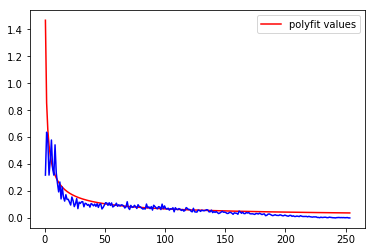

In [50]:
landindex = popindex.landCoor()
landindex.curveFit(1)

[0.6665642536228957, 1.2341723985118973]

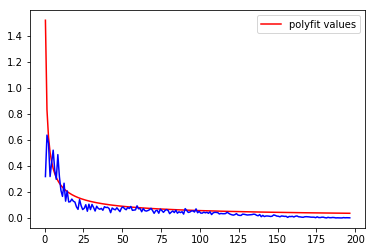

In [51]:
landindex2 = popindex[0:5000].landCoor()
landindex2.curveFit(1)

## test

In [5]:
demo = city(4,0.2,10000,fx,r0 = 3)
popindex = demo.step()

1 3 2
2 3 3
2 3 4
2 3 5
2 3 6
2 3 7
2 3 8
3 3 9
4 3 10
4 3 11
5 3 12
5 3 13
5 3 14
5 3 15
5 3 16
5 3 17
5 3 18
5 3 19
5 3 20
7 3 21
7 3 22
7 3 23
7 3 24
7 3 25
7 3 26
7 3 27
7 3 28
8 3 29
8 3 30
8 3 31
8 3 32
8 3 33
10 3 34
10 3 35
10 3 36
10 3 37
10 3 38
13 3 39
13 3 40
13 3 41
13 3 42
13 3 43
13 3 44
13 3 45
13 3 46
13 3 47
13 3 48
13 3 49
13 3 50
13 3 51
15 3 52
15 3 53
15 3 54
15 3 55
15 3 56
15 3 57
15 3 58
15 3 59
15 3 60
15 3 61
15 3 62
15 3 63
15 3 64
15 3 65
15 3 66
15 3 67
15 3 68
15 3 69
15 3 70
15 3 71
15 3 72
15 3 73
15 3 74
15 3 75
15 3 76
15 3 77
15 3 78
15 3 79
15 3 80
15 3 81
15 3 82
15 3 83
15 3 84
15 3 85
15 3 86
15 3 87
15 3 88
15 3 89
15 3 90
15 3 91
15 3 92
15 3 93
15 3 94
15 3 95
15 3 96
15 3 97
15 3 98
15 3 99
15 3 100
15 3 101
15 3 102
15 3 103
15 3 104
15 3 105
15 3 106
15 3 107
15 3 108
15 3 109
15 3 110
15 3 111
15 3 112
15 3 113
15 3 114
15 3 115
15 3 116
15 3 117
15 3 118
15 3 119
15 3 120
15 3 121
15 3 122
15 3 123
15 3 124
15 3 125
15 3 126
15 3 127
15 3

77 13 1034
77 13 1035
77 13 1036
77 13 1037
77 13 1038
77 13 1039
77 13 1040
77 13 1041
85 13 1042
85 13 1043
85 13 1044
85 13 1045
85 13 1046
85 13 1047
85 13 1048
85 13 1049
85 13 1050
85 13 1051
85 13 1052
85 13 1053
85 13 1054
85 13 1055
85 13 1056
85 13 1057
85 13 1058
85 13 1059
85 13 1060
85 13 1061
85 13 1062
85 13 1063
85 13 1064
88 13 1065
88 13 1066
88 13 1067
88 13 1068
88 13 1069
88 13 1070
88 13 1071
88 13 1072
88 13 1073
97 13 1074
97 13 1075
97 13 1076
97 13 1077
97 13 1078
97 13 1079
97 13 1080
97 13 1081
97 13 1082
97 13 1083
97 13 1084
97 13 1085
97 13 1086
97 13 1087
97 13 10

limit_output extension: Maximum message size of 10000 exceeded with 11499 characters

In [ ]:
popindex.paint()

In [ ]:
popindex.curveFit(1)

In [ ]:
landindex = popindex.landCoor()
landindex.curveFit(1)

In [ ]:
popindex[8000:8005]

In [6]:
popindex.curveDensity(1)

KeyboardInterrupt: 